In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import lightgbm as lgbm

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

In [4]:
df = load_pkl('./data/feat_engin/lgbm/data_1hour_1day.pkl')

In [5]:
df.shape

(1013212, 610)

In [8]:
# VEON-RX
df = df[df['ticker'] != 'VEON-RX']
df.shape

(1007027, 610)

In [11]:
df.head()

,time,close,ticker,index_1day,result,delta_time,income_rate,res_price,res_ind,close_w1_roc,...,tmos_close_1day_w100_ma_up_3std/tmos_close_1day,close_1day_w3_min/close_1day_w3_max,volume_1day_w3_min/volume_1day_w3_max,tmos_close_1day_w3_min/tmos_close_1day_w3_max,close_1day_w5_min/close_1day_w5_max,volume_1day_w5_min/volume_1day_w5_max,tmos_close_1day_w5_min/tmos_close_1day_w5_max,close_1day_w20_min/close_1day_w20_max,volume_1day_w20_min/volume_1day_w20_max,tmos_close_1day_w20_min/tmos_close_1day_w20_max
0,2022-05-05 10:00:00,31.24,AFLT,0.0,LOSE,1 days 00:00:00,0.98,30.379999,18,0.001282,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2022-05-05 11:00:00,30.98,AFLT,0.0,LOSE,1 days 01:00:00,0.98,30.280001,20,-0.008323,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2022-05-05 12:00:00,30.92,AFLT,0.0,LOSE,1 days 00:00:00,0.98,30.280001,20,-0.001937,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2022-05-05 13:00:00,30.92,AFLT,0.0,LOSE,0 days 23:00:00,0.98,30.280001,20,0.000000,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2022-05-05 14:00:00,31.00,AFLT,0.0,LOSE,0 days 22:00:00,0.98,30.280001,20,0.002587,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [13]:
df['result'].value_counts(normalize=True)

result
DNF     0.472023
LOSE    0.361183
WIN     0.166794
Name: proportion, dtype: float64

In [15]:
df['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.980000
0.01    0.980000
0.10    0.980000
0.20    0.980000
0.30    0.980000
0.40    0.988029
0.50    0.996794
0.60    1.003744
0.70    1.012255
0.80    1.026473
0.90    1.040000
0.99    1.040000
1.00    1.040000
Name: income_rate, dtype: float64

## CHANGE TARGET

In [19]:
def get_target(df_all, ind, val_first, val_second, points_to_wait):
    #цель - достичь val_second, не достигнув val_first

    ind_end = min(ind+points_to_wait+1, df_all.shape[0])
    
    df = df_all.iloc[ind:ind_end].copy()
    
    mask_stock = np.array(df['ticker'] == df['ticker'].iloc[0])
    df = df.loc[mask_stock, :]

    start_price = df['close'].iloc[0]
    
    if val_first < val_second:                                 
        mask_val_first = np.array(df['close'] < val_first)
        mask_val_second = np.array(df['close'] > val_second)
    else: #short game
        mask_val_first = np.array(df['close'] > val_first)
        mask_val_second = np.array(df['close'] < val_second)

    
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() == 0):

        ind_end = df.shape[0]-1
        delta_time = df['time'].iloc[ind_end] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_end]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'DNF', delta_time, income_rate, res_price, ind_end+ind
        
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() != 0):
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_second]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind
        
    if (mask_val_first.sum() != 0) & (mask_val_second.sum() == 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_first]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind

    if (mask_val_first.sum() != 0) & (mask_val_second.sum() != 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        if ind_val_first < ind_val_second:
            delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_first]
            if val_first < val_second:
                income_rate = res_price/start_price
            else: #short game
                income_rate = (2*start_price-res_price)/start_price
            return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind
        if ind_val_first > ind_val_second:
            delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_second]
            if val_first < val_second:
                income_rate = res_price/start_price
            else:  #short game
                income_rate = (2*start_price-res_price)/start_price
            return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind


def get_df_target(df, indx, percent_first=None, percent_second=None, points_to_wait=None):
    times = []
    results = []
    delta_times = []
    income_rates = []
    closes = []
    tickers = []
    res_prices = []
    res_inds = []
    
    #for ind in indx:
    for ind in tqdm(indx):
        time = df['time'].iloc[ind]
        close = df['close'].iloc[ind]
        ticker = df['ticker'].iloc[ind]
        
        val_first = df['close'].iloc[ind] * percent_first
        val_second = df['close'].iloc[ind] * percent_second
        result, delta_time, income_rate, res_price, res_ind = get_target(df, ind, val_first, val_second, points_to_wait)
        
        times += [time]
        closes += [close]
        tickers += [ticker]
        results += [result]
        delta_times += [delta_time]
        income_rates += [income_rate]
        res_prices += [res_price]
        res_inds += [res_ind]
        

    df_result = pd.DataFrame({'ind' : indx,
                              'time' : times,
                              'close' : closes,
                              'result' : results,
                              'ticker' : tickers, 
                              'delta_time' : delta_times,
                              'income_rate' : income_rates,
                              'res_price' : res_prices,
                              'res_ind' : res_inds
                             })
    return df_result    

In [21]:
df_result = load_pkl('./data/feat_engin/lgbm/df_result_wait_14_2days.pkl')
df_result = df_result[['time', 'close', 'ticker']]
df_result

,time,close,ticker
0,2022-05-04 10:00:00,32.100,AFLT
1,2022-05-04 11:00:00,31.380,AFLT
2,2022-05-04 12:00:00,31.800,AFLT
3,2022-05-04 13:00:00,31.360,AFLT
4,2022-05-04 14:00:00,31.540,AFLT
...,...,...,...
1014345,2025-02-04 19:00:00,11.095,RBCM
1014346,2025-02-04 20:00:00,11.090,RBCM
1014347,2025-02-04 21:00:00,11.105,RBCM
1014348,2025-02-04 22:00:00,11.070,RBCM


In [23]:
inds = np.arange(df_result.shape[0])
inds.shape

(1014350,)

In [25]:
df_result = get_df_target(df_result, inds, percent_first=0.995, percent_second=1.02, points_to_wait=14*1)
df_result["income_rate"] = np.maximum(df_result["income_rate"], 0.995)
df_result["income_rate"] = np.minimum(df_result["income_rate"], 1.02)

100%|█████████████████████████████████████████████████████████████| 1014350/1014350 [04:03<00:00, 4172.55it/s]


In [26]:
df_result['result'].value_counts(normalize=True)

result
LOSE    0.611016
DNF     0.205634
WIN     0.183350
Name: proportion, dtype: float64

In [27]:
df_result['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.995000
0.01    0.995000
0.10    0.995000
0.20    0.995000
0.30    0.995000
0.40    0.995000
0.50    0.995000
0.60    0.995000
0.70    1.003430
0.80    1.014757
0.90    1.020000
0.99    1.020000
1.00    1.020000
Name: income_rate, dtype: float64

In [28]:
(df_result['ind'] == df_result.index).all()

True

In [30]:
df_result = df_result[['time','result', 'ticker', 'delta_time', 'income_rate',
       'res_price', 'res_ind']]

In [32]:
df.shape

(1007027, 610)

In [34]:
#join
df = df[df.columns[~df.columns.isin(['result', 'delta_time', 'income_rate', 'res_price', 'res_ind'])]].merge(
    df_result, how='inner', on=['time', 'ticker'])
df.shape

(1007027, 610)

### 1. train/valid/test/test2 split

In [38]:
df['income_rate'] -= 0.001

In [39]:
df['target'] = (df['result'] == 'WIN').astype(int)

<Axes: xlabel='time'>

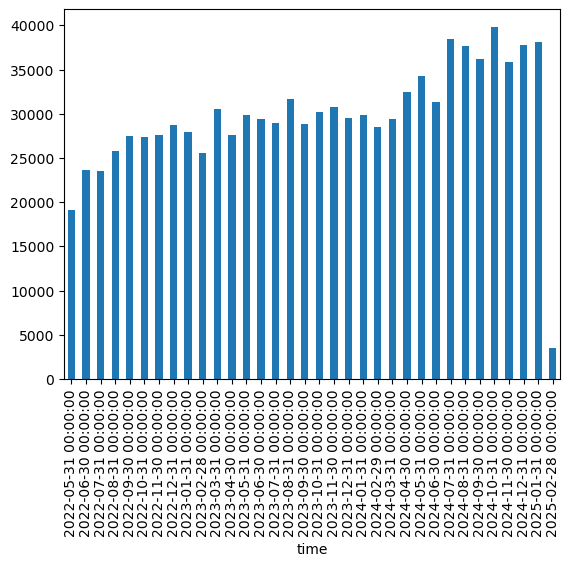

In [40]:
df[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.count().plot.bar()

<Axes: xlabel='time'>

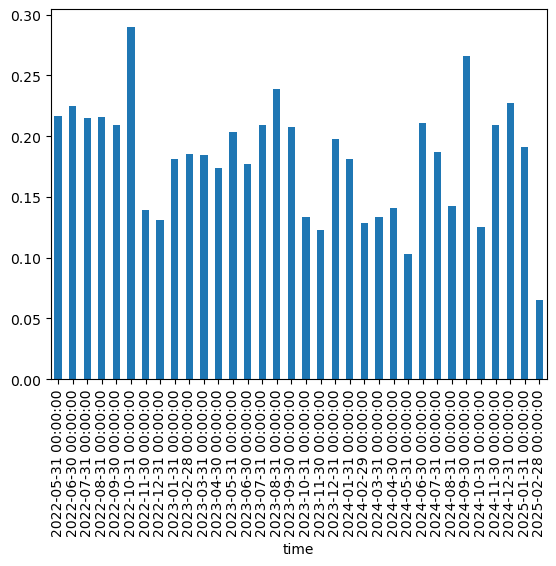

In [41]:
df[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.mean().plot.bar()

<Axes: xlabel='time'>

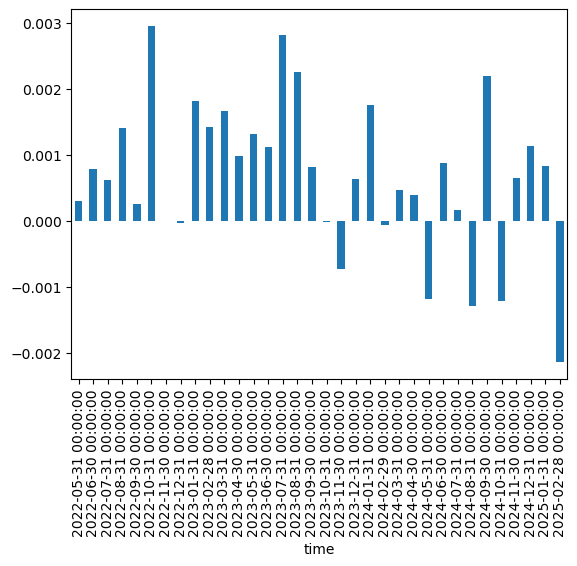

In [42]:
(df[['time', 'income_rate']].groupby(pd.Grouper(key='time', freq='ME')).income_rate.mean()-1).plot.bar()

In [44]:
pd.set_option('display.max_rows', 150)
df[['ticker', 'target']].groupby('ticker').target.mean().sort_values()

ticker
IRAO     0.100358
GAZP     0.102704
SBERP    0.104171
PHOR     0.104476
LKOH     0.105440
MTSS     0.107342
HYDR     0.108265
TATNP    0.112903
SBER     0.113019
AKRN     0.113422
GMKN     0.118601
VSMO     0.121938
ROSN     0.123014
TATN     0.124829
TRNFP    0.129659
CBOM     0.132281
NVTK     0.132835
RTKM     0.132940
ALRS     0.133130
RTKMP    0.134482
MOEX     0.134836
RUAL     0.139366
VTBR     0.142721
MGNT     0.144917
MAGN     0.145654
SNGSP    0.146724
SGZH     0.150829
SIBN     0.152051
BELU     0.152291
POSI     0.154588
PLZL     0.158533
APTK     0.158986
CHMF     0.159108
KRKNP    0.160173
OGKB     0.161075
ENPG     0.161079
NLMK     0.161650
UPRO     0.165839
SNGS     0.168897
AFLT     0.169159
SMLT     0.170237
AQUA     0.170408
AFKS     0.171705
PIKK     0.174953
LNZL     0.176015
KAZT     0.177219
FEES     0.177482
LSNGP    0.180527
YAKG     0.180626
NKNCP    0.180772
KAZTP    0.181008
MSNG     0.181337
LNZLP    0.181920
ABRD     0.182670
MVID     0.182710
TGK

In [45]:
df[['ticker', 'income_rate']].groupby('ticker').income_rate.mean().sort_values()

ticker
VSMO     0.999199
LNZL     0.999857
YAKG     0.999869
GAZP     0.999882
LNZLP    0.999905
AKRN     0.999918
APTK     0.999961
RKKE     0.999991
KRKNP    1.000002
HYDR     1.000003
GMKN     1.000103
SGZH     1.000149
PHOR     1.000150
MGTSP    1.000168
RUAL     1.000170
ABIO     1.000223
CNTLP    1.000227
KAZTP    1.000237
ENPG     1.000302
NVTK     1.000303
SPBE     1.000326
VTBR     1.000340
ABRD     1.000342
UNKL     1.000349
MRKS     1.000356
NKHP     1.000374
KZOSP    1.000378
SMLT     1.000385
MTSS     1.000420
KROT     1.000446
RTKM     1.000454
KMAZ     1.000462
SVAV     1.000497
ALRS     1.000505
KAZT     1.000514
MAGN     1.000550
WUSH     1.000552
SELG     1.000565
IRKT     1.000579
TGKBP    1.000583
IRAO     1.000589
UNAC     1.000589
MVID     1.000591
AQUA     1.000629
RTKMP    1.000630
MGNT     1.000634
PIKK     1.000657
LIFE     1.000677
PRFN     1.000686
TRNFP    1.000686
MSTT     1.000693
UPRO     1.000694
NLMK     1.000694
ROLO     1.000723
ELFV     1.000725
NSV

In [46]:
df['time'].max()

Timestamp('2025-02-04 23:00:00')

In [47]:
mask_train = np.array((pd.Timestamp('2022-01-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-06-01')))
mask_valid = np.array((pd.Timestamp('2024-06-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-08-01')))
mask_test = np.array((pd.Timestamp('2024-08-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-10-01')))
mask_test2 = np.array((pd.Timestamp('2024-10-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-12-23')))
mask_test3 = np.array((pd.Timestamp('2024-12-23') <= df['time']) & (df['time'] < pd.Timestamp('2025-02-04')))

In [48]:
mask_test3.sum()

51841

In [49]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(708395, 69770, 73874, 101413)

In [51]:
# некоторые акции имеют более короткую историю
NEED_POINTS = 101
mask_avbl_all = np.zeros_like(mask_train).astype(bool)
for ticker in df["ticker"].unique():
    mask = np.array(df['ticker'] == ticker)
    count_days = df.loc[mask, 'time'].dt.date.nunique()
    if count_days < NEED_POINTS:
        mask_avbl = np.zeros_like(mask_train).astype(bool)
    else:
        date_first_avbl =  np.sort(df.loc[mask, 'time'].dt.date.unique())[NEED_POINTS]
        #print(date_first_avbl)
        mask_avbl = np.array(df["time"] >= pd.to_datetime(date_first_avbl))
    
    mask_ticker = np.array(df['ticker'] == ticker)
    mask_avbl_ticker = mask_ticker & mask_avbl

    mask_avbl_all |= mask_avbl_ticker

mask_train &= mask_avbl_all
mask_valid &= mask_avbl_all
mask_test &= mask_avbl_all
mask_test2 &= mask_avbl_all


#мб дату неправильно обрезаю

In [52]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(592135, 69770, 73874, 101413)

In [56]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

837192

In [57]:
df.loc[mask_data].isnull().sum()[df.loc[mask_data].isnull().sum() > 0].sort_values()

Series([], dtype: int64)

In [60]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.7072869783753308,
 0.08333811120985389,
 0.08824021251994764,
 0.12113469789486761)

In [62]:
df.loc[mask_train, 'target'].mean(), df.loc[mask_valid, 'target'].mean(), df.loc[mask_test, 'target'].mean(), df.loc[mask_test2, 'target'].mean()

(0.17256368902361793,
 0.19766375232908126,
 0.20289953163494598,
 0.17938528591009043)

In [63]:
# long 0.5-1% = (0.3208786045692136, 0.34119978896034453, 0.34584248171446275, 0.3278709436850524)
# long 1-2% = (0.20169646527783605, 0.2333128948081393, 0.24120745160899257, 0.2177432807700988)
# long 0.5-1.5% = (0.23314064217335492, 0.2585378374139087, 0.2621533156427215, 0.24212778066706572)
# long 0.6-1.2% = (0.2939113508796953, 0.3194113704744114, 0.32313204649847116, 0.3044971494176177)
# long 0.75-1.5% = (0.2566209969040767, 0.2857163227765974, 0.292043265668988, 0.27175224955597643)
# long 0.5-2% = (0.1727760112090881, 0.19779263927904292, 0.2026832257977613, 0.18010185557703443)

#short 0.5-1% = (0.3169873058755422, 0.39845142523064636, 0.4000323280216598, 0.39971935746597453)

In [65]:
df.loc[mask_test3, 'target'].mean()

0.20018903956328002

In [66]:
df.loc[mask_train, 'income_rate'].mean(), df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(1.0008924185821724, 1.0004854335369233, 1.000418526133866, 0.9999065646172048)

In [67]:
# long 0.5-1%.  = (1.0007682873149386, 1.000494108454634, 1.0004500861047736, 1.0002426395566486)
# long 1-2%     = (1.0012801856417568, 1.0003689898634218, 1.0003750421110214, 0.9998243161720928)
# long 0.5-1.5% = (1.001412311144123, 1.001058324382, 1.0009595677557406, 1.0006372138114736) 
# long 0.6-1.2% = (1.000879508823968, 1.0004766326739345, 1.0003884553358984, 1.0001372273093823)
# long 0.75-1.5% = (1.0010534617907283, 1.000418445826947, 1.0003675931393845, 1.000030532859974)
# long 0.5-2% = (1.0018869217892465, 1.0014885095832067, 1.0014088163934738, 1.0009177017419724) #<--

#short 0.5-1% = (1.0008479961575805, 1.0014144396777953, 1.0013580368179469, 1.0014273808299112)

In [68]:
df.loc[mask_test3, 'income_rate'].mean()

1.0011144279960962

In [71]:
#проверки

In [72]:
(mask_train.sum()+mask_valid.sum()+mask_test.sum()+mask_test2.sum()) ==(mask_data).sum()

#(mask_train.sum()+mask_valid.sum()+mask_test.sum()) ==(mask_data).sum()

True

## 3. Model

## 3.1 Base model

In [80]:
df['ticker_code'] = df['ticker'].astype('category').cat.codes

In [81]:
df['ticker_code'].nunique()

127

In [82]:
df.loc[mask_train, 'ticker_code'].nunique()

127

In [83]:
df.columns.tolist()

['time',
 'close',
 'ticker',
 'index_1day',
 'close_w1_roc',
 'volume_w1_roc',
 'tmos_close_w1_roc',
 'close_w5_norm_std',
 'close_w5_mean_abs_pct',
 'close_w5_alpha',
 'close_w5_rsi',
 'close_w5_roc',
 'volume_w5_norm_std',
 'volume_w5_mean_abs_pct',
 'volume_w5_alpha',
 'volume_w5_rsi',
 'volume_w5_roc',
 'tmos_close_w5_norm_std',
 'tmos_close_w5_mean_abs_pct',
 'tmos_close_w5_alpha',
 'tmos_close_w5_rsi',
 'tmos_close_w5_roc',
 'close_w14_norm_std',
 'close_w14_mean_abs_pct',
 'close_w14_alpha',
 'close_w14_rsi',
 'close_w14_roc',
 'volume_w14_norm_std',
 'volume_w14_mean_abs_pct',
 'volume_w14_alpha',
 'volume_w14_rsi',
 'volume_w14_roc',
 'tmos_close_w14_norm_std',
 'tmos_close_w14_mean_abs_pct',
 'tmos_close_w14_alpha',
 'tmos_close_w14_rsi',
 'tmos_close_w14_roc',
 'close_w70_norm_std',
 'close_w70_mean_abs_pct',
 'close_w70_alpha',
 'close_w70_rsi',
 'close_w70_roc',
 'close_w70_lvl_1-1.005',
 'close_w70_lvl_-0.995-1',
 'close_w70_lvl_1.005-1.01',
 'close_w70_lvl_-0.99-0.995',

In [84]:
drop_cols = ['time',
             #'ticker_code',
             #'hour', 'day', 'weekday', 

 'ticker',
 'index_1day',
 'result',
 'delta_time',
 'income_rate',
 'res_price',
 'res_ind', 'index', 'target', 
              'ind', 'close',
             'y_pred'] #+ [elem for elem in df.columns if 'roc' in elem]


features = df.columns[~df.columns.isin(drop_cols)].tolist()
#features = [elem for elem in df.columns if (('/' in elem) or ('lvl' in elem) or ('alpha' in elem))] +['hour', 'day', 'weekday'] + #['ticker_code']
                                                                                                    


cat_features_all = ['ticker_code',
                'hour', 'day', 'weekday',# 'month'
]
cat_features = cat_features_all

target = 'target'

In [778]:
len(features)

601

### Get stability features

In [783]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    "num_leaves": 2,

     "bagging_fraction": 0.5,
     "bagging_freq": 1,
     "verbose": 0,
    "metric": "auc",
    "early_stopping" : 20, 
}

auc_features = {'feature' : [],
               'auc_train' : [],
               'auc_valid' : [],
               'auc_test' : [],
               'auc_test2' : []
               }

for feature in tqdm(features):
    stab_features = [feature]
    stab_cat_features = [feature] if feature in cat_features else []
    
    D_train = lgbm.Dataset(df.loc[mask_train, stab_features], label=df.loc[mask_train, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_valid = lgbm.Dataset(df.loc[mask_valid, stab_features], label=df.loc[mask_valid, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_test = lgbm.Dataset(df.loc[mask_test, stab_features], label=df.loc[mask_test, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_test2 = lgbm.Dataset(df.loc[mask_test2, stab_features], label=df.loc[mask_test2, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
        
    model = lgbm.train(params, num_boost_round=1_000, train_set=D_train, valid_sets=[D_valid])
    
    y_pred_train = model.predict(D_train.data)
    y_pred_valid = model.predict(D_valid.data)
    y_pred_test = model.predict(D_test.data)
    y_pred_test2 = model.predict(D_test2.data)

    auc_features['feature'] += [feature]
    auc_features['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
    auc_features['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
    auc_features['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
    auc_features['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]

auc_features_cp = auc_features.copy()

100%|███████████████████████████████████████████████████████████████████████| 601/601 [03:37<00:00,  2.76it/s]


In [785]:
df_auc_features = pd.DataFrame(auc_features)
df_auc_features

,feature,auc_train,auc_valid,auc_test,auc_test2
0,close_w1_roc,0.558442,0.554226,0.534278,0.548896
1,volume_w1_roc,0.511710,0.504156,0.500478,0.493108
2,tmos_close_w1_roc,0.537296,0.553275,0.543822,0.531585
3,close_w5_norm_std,0.585497,0.586655,0.555379,0.570892
4,close_w5_mean_abs_pct,0.594884,0.597866,0.563611,0.579698
...,...,...,...,...,...
596,tmos_close_1day_w5_min/tmos_close_1day_w5_max,0.574403,0.548200,0.543895,0.592635
597,close_1day_w20_min/close_1day_w20_max,0.606781,0.599160,0.592269,0.574053
598,volume_1day_w20_min/volume_1day_w20_max,0.570789,0.548314,0.533908,0.514693
599,tmos_close_1day_w20_min/tmos_close_1day_w20_max,0.570464,0.562763,0.574153,0.498795


#### auc <=0.525

In [788]:
auc_treshold = 0.51

In [789]:
mask_auc_train  = df_auc_features['auc_train'] <= auc_treshold 
mask_auc_train.sum()

67

In [790]:
mask_auc_valid  = df_auc_features['auc_valid'] <= auc_treshold 
mask_auc_valid.sum()

162

In [791]:
mask_auc_test  = df_auc_features['auc_test'] <= auc_treshold 
mask_auc_test.sum()

221

In [792]:
(mask_auc_train | mask_auc_valid | mask_auc_test).sum()

281

In [794]:
mask_auc_test2  = df_auc_features['auc_test2'] <= auc_treshold 
mask_auc_test2.sum()

230

In [795]:
(mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_test2).sum()

321

#### delta_auc > 0.05

In [1743]:
auc_delta_treshold  = 0.025

In [1745]:
mask_auc_delta_valid = (df_auc_features['auc_train'] - df_auc_features['auc_valid']).abs() > auc_delta_treshold
mask_auc_delta_valid.sum()

163

In [1747]:
mask_auc_delta_test = (df_auc_features['auc_train'] - df_auc_features['auc_test']).abs() > auc_delta_treshold
mask_auc_delta_test.sum()

184

In [1749]:
(mask_auc_delta_valid | mask_auc_delta_test).sum()

264

In [1752]:
mask_auc_delta_test2 = (df_auc_features['auc_train'] - df_auc_features['auc_test2']).abs() > auc_delta_treshold
mask_auc_delta_test2.sum()

196

In [1754]:
(mask_auc_delta_valid | mask_auc_delta_test | mask_auc_delta_test2).sum()

326

#### union criterias

In [1758]:
mask_criterias1 = mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_delta_valid | mask_auc_delta_test
mask_criterias1.sum()

420

In [1760]:
mask_criterias2 = mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_test2 | mask_auc_delta_valid | mask_auc_delta_test | mask_auc_delta_test2
mask_criterias2.sum()

463

In [1763]:
features_criteria1 = df_auc_features['feature'].values[~mask_criterias1]
len(features_criteria1), features_criteria1

(181,
 array(['close_w1_roc', 'tmos_close_w1_roc', 'close_w5_alpha',
        'volume_w5_alpha', 'tmos_close_w5_norm_std',
        'tmos_close_w5_mean_abs_pct', 'tmos_close_w5_roc',
        'close_w14_norm_std', 'close_w14_mean_abs_pct', 'close_w14_alpha',
        'close_w14_roc', 'volume_w14_norm_std', 'tmos_close_w14_norm_std',
        'tmos_close_w14_alpha', 'tmos_close_w14_roc', 'close_w70_norm_std',
        'close_w70_lvl_1-1.005', 'close_w70_lvl_-0.995-1',
        'close_w70_lvl_1.005-1.01', 'close_w70_lvl_-0.99-0.995',
        'close_w70_lvl_1.01-1.02', 'close_w70_lvl_-0.98-0.99',
        'close_w70_lvl_1.02-1.03', 'volume_w70_norm_std',
        'volume_w70_mean_abs_pct', 'volume_w70_alpha', 'volume_w70_roc',
        'close_w1_roc/close_w5_alpha', 'close_w1_roc/close_w14_alpha',
        'close_w1_roc/close_w70_alpha', 'volume_w1_roc/volume_w5_alpha',
        'volume_w1_roc/volume_w70_alpha',
        'tmos_close_w1_roc/tmos_close_w5_alpha',
        'tmos_close_w1_roc/tmos_close_w1

In [1765]:
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria1)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2
231,close_w70_min/close_w70_max,0.619991,0.618247,0.599756,0.590993
19,close_w14_mean_abs_pct,0.612544,0.613478,0.596486,0.610997
491,close_1day/close_1day_w20_ma,0.589428,0.613311,0.576529,0.585460
496,close_1day_w5_ma/close_1day_w20_ma,0.587914,0.612838,0.565864,0.593174
494,close_1day_w3_ma/close_1day_w20_ma,0.590320,0.604338,0.570502,0.591723
...,...,...,...,...,...
109,volume_w5_roc/volume_w70_roc,0.524196,0.511023,0.513373,0.510768
130,volume_w5_std/volume_w70_std,0.522176,0.510916,0.517387,0.496918
289,volume_1day_w20_rsi,0.511031,0.510772,0.528702,0.532852
146,close_w14_rsi/close_w70_rsi,0.512061,0.510716,0.530310,0.532485


In [1823]:
features_criteria2 = df_auc_features['feature'].values[~mask_criterias2]
len(features_criteria2), features_criteria2

(138,
 array(['close_w1_roc', 'tmos_close_w1_roc', 'tmos_close_w5_norm_std',
        'tmos_close_w5_mean_abs_pct', 'tmos_close_w5_roc',
        'close_w14_norm_std', 'close_w14_mean_abs_pct', 'close_w14_alpha',
        'close_w14_roc', 'volume_w14_norm_std', 'tmos_close_w14_norm_std',
        'tmos_close_w14_alpha', 'tmos_close_w14_roc', 'close_w70_norm_std',
        'close_w70_lvl_1-1.005', 'close_w70_lvl_-0.995-1',
        'close_w70_lvl_1.005-1.01', 'close_w70_lvl_-0.99-0.995',
        'close_w70_lvl_1.01-1.02', 'close_w70_lvl_-0.98-0.99',
        'close_w70_lvl_1.02-1.03', 'volume_w70_norm_std',
        'volume_w70_alpha', 'close_w1_roc/close_w5_alpha',
        'close_w1_roc/close_w14_alpha', 'close_w1_roc/close_w70_alpha',
        'volume_w1_roc/volume_w70_alpha',
        'tmos_close_w1_roc/tmos_close_w5_alpha',
        'tmos_close_w1_roc/tmos_close_w70_alpha',
        'volume_w1_roc/volume_w70_roc', 'volume_w5_roc/volume_w70_roc',
        'tmos_close_w1_roc/tmos_close_w5_roc',
  

In [1825]:
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria2)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2
19,close_w14_mean_abs_pct,0.612544,0.613478,0.596486,0.610997
491,close_1day/close_1day_w20_ma,0.589428,0.613311,0.576529,0.585460
496,close_1day_w5_ma/close_1day_w20_ma,0.587914,0.612838,0.565864,0.593174
494,close_1day_w3_ma/close_1day_w20_ma,0.590320,0.604338,0.570502,0.591723
33,close_w70_norm_std,0.610334,0.604256,0.595317,0.587669
228,close_w14_min/close_w14_max,0.603177,0.600753,0.583880,0.589462
18,close_w14_norm_std,0.601390,0.599281,0.579927,0.583349
253,close_1day_w5_mean_abs_pct,0.591247,0.596983,0.580829,0.576935
271,close_1day_w20_roc,0.581609,0.592117,0.567384,0.562401
492,close_1day/close_1day_w100_ma,0.580056,0.591943,0.583444,0.563446


In [105]:
features = features_criteria2.tolist()
cat_features = [feature for feature in features if feature in cat_features_all]

In [107]:
len(features), len(cat_features)

(138, 0)

In [109]:
'ticker_code' in features

False

In [113]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [114]:
# D_test3 = lgbm.Dataset(df.loc[mask_test3, features], label=df.loc[mask_test3, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
# D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
# D_test3.time = df.loc[mask_test3, 'time'].values


In [118]:
def mean_income_rate_point(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    score = np.mean(D_sample.income_rate[mask]) - 1
    
    return score

def mean_income_rate_day(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean()

    return score
    
def mean_income_rate_month(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    
    return score


# def mean_income_rate(y_pred, data):
#     q = 0.98
#     mask = y_pred >= np.quantile(y_pred, q)
#     score = round(data.income_rate[mask].mean(), 5)
    
#     return 'mean_income_rate', score, True#is_higher_better

def mean_income_rate(y_pred, D_sample):
    q = 0.98
    mask = y_pred >= np.quantile(y_pred, q)
    #mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    score = round(score, 5)
    
    return 'mean_income_rate', score, True#is_higher_better

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    
    "num_boost_round" : 1_000,

    
    "num_leaves": 2,
    #"learning_rate": 0.001,
     "feature_fraction": 0.5,
     "bagging_fraction": 0.5,
     "bagging_freq": 1,
     'lambda_l1' : 10,
     'lambda_l2' : 10,
    #"verbose": 0,

    #'max_bin' : 100000,
    
    
    "metric": "auc",
    #"metric" : 'mean_income_rate',
    "early_stopping" : 50,



    
}


    

model = lgbm.train(params, train_set=D_train, valid_sets=[D_valid])#, feval=mean_income_rate, )

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 102971, number of negative: 492974
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28365
[LightGBM] [Info] Number of data points in the train set: 595945, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.172786 -> initscore=-1.566009
[LightGBM] [Info] Start training from score -1.566009
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	valid_0's auc: 0.640266


In [119]:
model.num_trees()

63

In [123]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.6459855842911483,
 0.6402661109820531,
 0.6074779317225273,
 0.6188628760736063)

In [126]:
#свой threshold

q = 0.95

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.554035
WIN     0.428001
DNF     0.017964
Name: proportion, dtype: float64
1.0048942148196645

Test
result
LOSE    0.596995
WIN     0.390394
DNF     0.012611
Name: proportion, dtype: float64
1.0039303532868473

Test2
result
LOSE    0.639851
WIN     0.298101
DNF     0.062047
Name: proportion, dtype: float64
1.0023091998863167


In [129]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.30461735479299595

Valid
result
LOSE    0.554035
WIN     0.428001
DNF     0.017964
Name: proportion, dtype: float64
1.0048942148196645

Test
result
LOSE    0.602315
WIN     0.374074
DNF     0.023611
Name: proportion, dtype: float64
1.0036158388064582

Tetst2
result
LOSE    0.642595
WIN     0.305590
DNF     0.051816
Name: proportion, dtype: float64
1.0023535672111774


In [211]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.95)
mask = df['y_pred'] >= threshold

mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.004894214819664455, 0.003615838806458216, 0.0023535672111774097)

In [213]:
#(0.00519963161109227, 0.004548106594387313, 0.005202952029520258)

In [215]:
df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(1.0004874471015146, 1.0004094145712945, 0.9999179834672731)

In [217]:
#(1.0014144396777953, 1.0013580368179469, 1.0014273808299112)

In [219]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.004125222338238156, 0.0047998480649103625, 0.004614483982067795)

In [221]:
#(0.004938866300974756, 0.006170416911948592, 0.0044445648451688635)
#(0.0031044329001512975, 0.0027255590235570337, 0.004087116017753346)

In [223]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.05909620838034195, 0.06876061413918101, 0.05334030636898706)

In [225]:
#(0.06822526936695361, 0.06629610728651743, 0.06960640537179712)

In [227]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 03:00:00'),
 Timedelta('0 days 04:00:00'),
 Timedelta('0 days 03:00:00'))

In [229]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(3507, 6480, 2451)

In [231]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(), df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(28, 28, 31)

In [235]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'MVID', 'OGKB', 'SPBE', 'MTLRP', 'SFIN', 'KMAZ', 'CBOM',
       'MSNG', 'FEES', 'FESH', 'KROT', 'LENT', 'VKCO', 'UPRO', 'MRKY',
       'SELG', 'SGZH', 'CHMK', 'ENPG', 'YAKG', 'PMSBP', 'RKKE', 'GEMC',
       'MRKZ', 'BANE', 'CNTL', 'PMSB', 'KRKNP', 'NMTP', 'TATN', 'AFKS',
       'UNKL', 'APTK', 'LNZL', 'GMKN', 'NSVZ', 'LIFE', 'RNFT', 'VRSB',
       'YDEX', 'UWGN', 'TGKN', 'ABRD', 'HYDR', 'ABIO', 'WUSH', 'RTKMP',
       'GTRK', 'NLMK', 'TATNP', 'CNTLP', 'BLNG', 'ALRS', 'VSMO', 'LSNG',
       'TRNFP', 'MGNT', 'NKHP', 'TGKB', 'ROLO', 'IRKT', 'MGTSP', 'MTLR',
       'TGKA', 'HEAD', 'RUAL', 'KLSB', 'SIBN', 'SNGS', 'MSTT', 'KAZTP',
       'DVEC', 'NVTK', 'RASP', 'VTBR', 'PHOR', 'TTLK', 'NKNC', 'T',
       'KAZT', 'AMEZ', 'MRKU', 'TRMK', 'VEON-RX', 'CHMF', 'RTKM', 'SMLT',
       'LNZLP', 'MRKC', 'MRKP', 'UNAC', 'KZOSP', 'GAZP', 'ROSN', 'BELU',
       'ELFV', 'FLOT', 'PIKK', 'SVAV', 'TGKBP', 'POSI', 'KZOS', 'MRKS',
       'MTSS', 'MAGN', 'PRFN', 'BANEP', 'BSPB', 'AQUA', 'RBCM'],


In [237]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_95753/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
NMTP,1.0,1.019000
NKNC,1.0,1.019000
PHOR,1.0,1.008144
AFLT,1.0,1.013976
RASP,1.0,1.019000
RUAL,1.0,0.994000
BSPB,1.0,1.019000
HYDR,1.0,1.019000
TGKA,1.0,1.019000


In [240]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: -x[1])

[('close_w70_norm_std', 27.12),
 ('close_w14_mean_abs_pct', 22.55),
 ('tmos_close_1day_w5_ma_up_3std/tmos_close_1day', 8.4),
 ('tmos_close_1day_w5_norm_std', 5.89),
 ('close_w14_norm_std', 3.78),
 ('close_1day_w100_lvl_1.01-1.02', 3.54),
 ('close_w14_min/close_w14_max', 3.33),
 ('tmos_close_1day_w20_rsi', 3.31),
 ('close_1day_w100_lvl_1.02-1.03', 2.87),
 ('close_1day_w100_lvl_1.03-1.04', 2.09),
 ('close_w1_roc', 2.04),
 ('close_1day_w5_ma/close_1day_w20_ma', 1.64),
 ('close_w70_lvl_1.01-1.02', 1.62),
 ('volume_w70_alpha', 1.32),
 ('close_w70_lvl_1.005-1.01', 1.2),
 ('tmos_close_1day_w5_max/tmos_close_1day', 1.12),
 ('tmos_close/tmos_close_w70_ma', 1.11),
 ('close_1day_w5_mean_abs_pct/close_1day_w20_mean_abs_pct', 1.11),
 ('tmos_close_w14_norm_std', 1.05),
 ('close_w5_max/close', 0.93),
 ('tmos_close_w14_ma/tmos_close_w70_ma', 0.69),
 ('close_1day_w3_ma/close_1day_w100_ma', 0.63),
 ('volume_1day/volume_1day_w100_ma', 0.62),
 ('close_1day_w100_lvl_1.005-1.01', 0.53),
 ('close_1day_w20_ro

# 3.2 Tuning hyperparams

In [245]:
top_features = [elem[0] for elem in zip(features, model.feature_importance(importance_type='gain')) if elem[1] > 0]
top_cat_features = [elem for elem in top_features if elem in cat_features]

In [247]:
len(top_features), len(top_cat_features)

(27, 0)

In [249]:
top_features

['close_w1_roc',
 'close_w14_norm_std',
 'close_w14_mean_abs_pct',
 'tmos_close_w14_norm_std',
 'close_w70_norm_std',
 'close_w70_lvl_1.005-1.01',
 'close_w70_lvl_1.01-1.02',
 'volume_w70_alpha',
 'tmos_close/tmos_close_w14_ma',
 'tmos_close/tmos_close_w70_ma',
 'tmos_close_w14_ma/tmos_close_w70_ma',
 'close_w5_max/close',
 'close_w14_min/close_w14_max',
 'tmos_close_1day_w5_norm_std',
 'close_1day_w20_roc',
 'tmos_close_1day_w20_rsi',
 'close_1day_w100_lvl_1.005-1.01',
 'close_1day_w100_lvl_1.01-1.02',
 'close_1day_w100_lvl_1.02-1.03',
 'close_1day_w100_lvl_1.03-1.04',
 'close_1day_w5_mean_abs_pct/close_1day_w20_mean_abs_pct',
 'close_1day_w3_ma/close_1day_w100_ma',
 'close_1day_w5_ma/close_1day_w20_ma',
 'volume_1day/volume_1day_w100_ma',
 'tmos_close_1day_w5_max/tmos_close_1day',
 'tmos_close_1day_w5_ma_up_3std/tmos_close_1day',
 'close_1day_w100_ma_up_2std/close_1day']

In [252]:
D_train = lgbm.Dataset(df.loc[mask_train, top_features], label=df.loc[mask_train, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, top_features], label=df.loc[mask_valid, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, top_features], label=df.loc[mask_test, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, top_features], label=df.loc[mask_test2, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)

D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [254]:
D_train.data.shape

(595945, 27)

In [257]:
def mean_income_rate_point(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    score = np.mean(D_sample.income_rate[mask]) - 1
    
    return score

def mean_income_rate_day(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean()

    return score
    
def mean_income_rate_month(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    
    return score

In [259]:
from IPython.display import clear_output

history = {'params' : [],
           'num_trees' : [],

          
           'auc_train' : [],
           'auc_valid' : [],
           'auc_test' : [],
           'auc_test2' : [],

          
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],

           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],

           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],
           
           'mir_point@2_train' : [],
           'mir_point@2_valid' : [],
           'mir_point@2_test' : [],
           'mir_point@2_test2' : [],
          
           
           'mir_day@2_train' : [],
           'mir_day@2_valid' : [],
           'mir_day@2_test' : [],
           'mir_day@2_test2' : [],


           'mir_month@2_train' : [],
           'mir_month@2_valid' : [],
           'mir_month@2_test' : [],
           'mir_month@2_test2' : [],
          
          }



pbar = tqdm(total=3*1*3*9*13)
# for lambda_x in [0.001, 0.01, 0.1, 1]:
#     for learning_rate in [0.1, 0.01, 0.001]:
#         for num_leaves in [2, 4, 8, 16, 32]:
#             for feature_fraction in np.arange(1, 0, -0.1):
#                 for bagging_fraction in np.arange(1, 0, -0.1):
for lambda_x in [1, 10, 100]:
    for learning_rate in [0.1]:
        for num_leaves in [2, 5, 8]:
            for feature_fraction in np.arange(0.5, 0.95, 0.05)[::-1]:
                for bagging_fraction in np.arange(0.3, 0.95, 0.05)[::-1]:
                    feature_fraction = min(feature_fraction, 1)
                    bagging_fraction = min(bagging_fraction, 1)

                    
                    params = {
                                "boosting_type": "gbdt",
                                "objective": "binary",
                            
                                
                                 "num_leaves": num_leaves,
                                 "learning_rate": learning_rate,
                                 "feature_fraction": feature_fraction,
                                 "bagging_fraction": bagging_fraction,
                                 "bagging_freq": 1,
                                 'lambda_l1' : lambda_x,
                                 'lambda_l2' : lambda_x,
                                
                                "verbose": -1,
                                    
                                "metric": "auc",
                                "early_stopping" : 50,
                            }
                    model = lgbm.train(params, num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])
                    
                    y_pred_train = model.predict(D_train.data)
                    y_pred_valid = model.predict(D_valid.data)
                    y_pred_test = model.predict(D_test.data)
                    y_pred_test2 = model.predict(D_test2.data)
                    
                    #history
                    history['params'] += [params.copy()]
                    history['num_trees'] += [model.num_trees()]
        
                    history['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
                    history['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
                    history['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
                    history['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]


                    threshold1 = np.quantile(y_pred_valid, q=0.99)
                    threshold2 = np.quantile(y_pred_valid, q=0.95)
                    
                    history['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]
                   
                    history['mir_point@2_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_point@2_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_point@2_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_point@2_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold2)]


                    history['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
                   
                    history['mir_day@2_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_day@2_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_day@2_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_day@2_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold2)]

                    
                    history['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]
                   
                    history['mir_month@2_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_month@2_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_month@2_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_month@2_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold2)]


                    
                    clear_output()
                    pbar.update(1)
                    
pbar.close()
                    

history_cp = history.copy()

100%|█████████████████████████████████████████████████████████████████████| 1053/1053 [25:17<00:00,  1.44s/it]


In [263]:
dump_pkl(history, './history_long.pkl')

In [265]:
history = load_pkl('./history_long.pkl')

In [267]:
pd.set_option('display.max_columns', 100)
df_hst = pd.DataFrame(history)
df_hst

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
0,"{'boosting_type': 'gbdt', 'objective': 'binary...",72,0.647643,0.641492,0.605358,0.621114,0.008909,0.006543,0.003007,0.001872,0.010952,0.004841,0.001561,0.005165,0.020354,0.029719,0.009585,0.021184,0.006514,0.004729,0.003751,0.002595,0.005850,0.004548,0.005181,0.004558,0.032029,0.060497,0.076878,0.052691
1,"{'boosting_type': 'gbdt', 'objective': 'binary...",74,0.648820,0.642585,0.605471,0.623241,0.008436,0.006615,0.003002,0.001439,0.010199,0.005737,0.004040,0.003704,0.017930,0.032288,0.020668,0.013813,0.006512,0.004855,0.003466,0.002361,0.005629,0.005484,0.004737,0.004816,0.028841,0.072952,0.065433,0.053872
2,"{'boosting_type': 'gbdt', 'objective': 'binary...",74,0.648681,0.642502,0.605438,0.623089,0.008991,0.006743,0.002912,0.001870,0.011078,0.004404,0.003869,0.008090,0.018919,0.022534,0.019794,0.027150,0.006538,0.004821,0.003508,0.002555,0.005245,0.003734,0.003877,0.004907,0.027659,0.049677,0.055537,0.056716
3,"{'boosting_type': 'gbdt', 'objective': 'binary...",88,0.651092,0.642656,0.607469,0.625637,0.008343,0.006229,0.002967,0.002094,0.008460,0.007788,0.003243,0.008897,0.017848,0.047816,0.023232,0.046447,0.006177,0.004805,0.003385,0.002777,0.005490,0.003192,0.003862,0.004346,0.037500,0.045724,0.057308,0.053476
4,"{'boosting_type': 'gbdt', 'objective': 'binary...",73,0.648338,0.642791,0.606701,0.622982,0.008621,0.006656,0.002996,0.001328,0.009213,0.004399,0.003943,0.005281,0.013883,0.022505,0.020175,0.021661,0.006513,0.004887,0.003490,0.002496,0.005444,0.004647,0.004939,0.005357,0.026253,0.057063,0.070760,0.061925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,"{'boosting_type': 'gbdt', 'objective': 'binary...",28,0.664666,0.654336,0.609837,0.611445,0.009567,0.005646,0.003412,0.002648,0.007998,0.006151,0.004998,0.006912,0.003615,0.012587,0.020455,0.012886,0.007797,0.004638,0.003389,0.002167,0.006536,0.004833,0.001853,0.004531,0.019040,0.046977,0.017065,0.032100
1049,"{'boosting_type': 'gbdt', 'objective': 'binary...",70,0.681965,0.650220,0.619215,0.598370,0.010774,0.005784,0.003054,0.001739,0.008915,0.006819,0.002607,0.004472,0.009852,0.013956,0.013339,0.008338,0.008054,0.004493,0.002715,0.001915,0.005986,0.003544,0.001736,0.003485,0.044496,0.041703,0.022210,0.037683
1050,"{'boosting_type': 'gbdt', 'objective': 'binary...",22,0.659420,0.645276,0.610021,0.613864,0.009513,0.005602,0.003101,0.002145,0.009891,0.006265,0.003365,0.005193,0.003478,0.012822,0.012051,0.005809,0.007755,0.004146,0.003360,0.001932,0.006740,0.003146,0.000759,0.007044,0.014896,0.022534,0.006211,0.039399
1051,"{'boosting_type': 'gbdt', 'objective': 'binary...",23,0.659465,0.650863,0.610775,0.620878,0.009667,0.005722,0.003361,0.002114,0.010811,0.005999,0.003633,0.005067,0.003258,0.012277,0.011152,0.005668,0.007912,0.004022,0.003352,0.002212,0.006727,0.010270,0.000588,0.003396,0.012164,0.047290,0.003609,0.008864


### threshold delta AUC

In [272]:
threshold = 0.03
mask_model_valid = (df_hst['auc_train'] - df_hst['auc_valid']) < threshold
mask_model_test = (df_hst['auc_train'] - df_hst['auc_test']) < threshold
mask_model_test2 = (df_hst['auc_train'] - df_hst['auc_test2']) < threshold
mask_model_valid.sum(), mask_model_test.sum(), mask_model_test2.sum()

(985, 0, 339)

In [274]:
(mask_model_valid&mask_model_test).sum(), (mask_model_valid&mask_model_test&mask_model_test2).sum()

(0, 0)

In [276]:
mask_auc = mask_model_valid&mask_model_test#&mask_model_test2
df_hst.loc[mask_auc].sort_values(by='auc_valid', ascending=False).iloc[:5]
#df_hst.loc[mask_model_valid&mask_model_test].sort_values(by='income_rate@1_valid', ascending=False).iloc[:5]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2


In [278]:
#1309

In [280]:
df_hst.columns

Index(['params', 'num_trees', 'auc_train', 'auc_valid', 'auc_test',
       'auc_test2', 'mir_point@1_train', 'mir_point@1_valid',
       'mir_point@1_test', 'mir_point@1_test2', 'mir_day@1_train',
       'mir_day@1_valid', 'mir_day@1_test', 'mir_day@1_test2',
       'mir_month@1_train', 'mir_month@1_valid', 'mir_month@1_test',
       'mir_month@1_test2', 'mir_point@2_train', 'mir_point@2_valid',
       'mir_point@2_test', 'mir_point@2_test2', 'mir_day@2_train',
       'mir_day@2_valid', 'mir_day@2_test', 'mir_day@2_test2',
       'mir_month@2_train', 'mir_month@2_valid', 'mir_month@2_test',
       'mir_month@2_test2'],
      dtype='object')

### threshold income_rate

In [296]:
col = 'mir_month@2'
threshold = 0.065
# mask_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask_ir_test = df_hst[f'{col}_test'] >= threshold
mask_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask_ir_valid.sum(), mask_ir_test.sum(), mask_ir_test2.sum()

(97, 80, 88)

In [298]:
(mask_ir_valid&mask_ir_test).sum(), (mask_ir_valid&mask_ir_test&mask_ir_test2).sum()

(21, 4)

In [300]:
mask_ir= mask_ir_valid&mask_ir_test&mask_ir_test2
mask_ir.sum()



4

In [305]:
col = 'mir_day@2'
threshold = 0.005

# mask2_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask2_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask2_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask2_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask2_ir_test = df_hst[f'{col}_test'] >= threshold
mask2_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask2_ir_valid.sum(), mask2_ir_test.sum(), mask2_ir_test2.sum()

(340, 33, 381)

In [307]:
(mask2_ir_valid&mask2_ir_test).sum(), (mask2_ir_valid&mask2_ir_test&mask2_ir_test2).sum()

(4, 3)

In [309]:
mask2_ir = mask2_ir_valid&mask2_ir_test&mask2_ir_test2
mask2_ir.sum()

3

In [312]:
(mask_ir&mask2_ir).sum()

1

In [314]:
df_hst.loc[mask_ir&mask2_ir].sort_values(by=f'auc_valid', ascending=False).iloc[:21]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
430,"{'boosting_type': 'gbdt', 'objective': 'binary...",87,0.650884,0.642613,0.606722,0.622893,0.008437,0.005779,0.003049,0.00109,0.009024,0.008,0.002552,0.00371,0.017677,0.049115,0.014364,0.017986,0.00634,0.004823,0.003464,0.002413,0.005921,0.005041,0.005135,0.005872,0.034199,0.069632,0.073568,0.070061


In [316]:
df_hst.iloc[[430]]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
430,"{'boosting_type': 'gbdt', 'objective': 'binary...",87,0.650884,0.642613,0.606722,0.622893,0.008437,0.005779,0.003049,0.00109,0.009024,0.008,0.002552,0.00371,0.017677,0.049115,0.014364,0.017986,0.00634,0.004823,0.003464,0.002413,0.005921,0.005041,0.005135,0.005872,0.034199,0.069632,0.073568,0.070061


In [320]:
df_hst['params'].iloc[430] #<---

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.6000000000000001,
 'bagging_fraction': 0.8499999999999999,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

In [2749]:
#df_hst['params'].iloc[2463]

# Feature selection

In [322]:
len(top_features), top_features

(27,
 ['close_w1_roc',
  'close_w14_norm_std',
  'close_w14_mean_abs_pct',
  'tmos_close_w14_norm_std',
  'close_w70_norm_std',
  'close_w70_lvl_1.005-1.01',
  'close_w70_lvl_1.01-1.02',
  'volume_w70_alpha',
  'tmos_close/tmos_close_w14_ma',
  'tmos_close/tmos_close_w70_ma',
  'tmos_close_w14_ma/tmos_close_w70_ma',
  'close_w5_max/close',
  'close_w14_min/close_w14_max',
  'tmos_close_1day_w5_norm_std',
  'close_1day_w20_roc',
  'tmos_close_1day_w20_rsi',
  'close_1day_w100_lvl_1.005-1.01',
  'close_1day_w100_lvl_1.01-1.02',
  'close_1day_w100_lvl_1.02-1.03',
  'close_1day_w100_lvl_1.03-1.04',
  'close_1day_w5_mean_abs_pct/close_1day_w20_mean_abs_pct',
  'close_1day_w3_ma/close_1day_w100_ma',
  'close_1day_w5_ma/close_1day_w20_ma',
  'volume_1day/volume_1day_w100_ma',
  'tmos_close_1day_w5_max/tmos_close_1day',
  'tmos_close_1day_w5_ma_up_3std/tmos_close_1day',
  'close_1day_w100_ma_up_2std/close_1day'])

In [326]:
top_features = ['close_w1_roc',
  'close_w14_norm_std',
  'close_w14_mean_abs_pct',
  'tmos_close_w14_norm_std',
  'close_w70_norm_std',
  'close_w70_lvl_1.005-1.01',
  'close_w70_lvl_1.01-1.02',
  'volume_w70_alpha',
  'tmos_close/tmos_close_w14_ma',
  'tmos_close/tmos_close_w70_ma',
  'tmos_close_w14_ma/tmos_close_w70_ma',
  'close_w5_max/close',
  'close_w14_min/close_w14_max',
  'tmos_close_1day_w5_norm_std',
  'close_1day_w20_roc',
  'tmos_close_1day_w20_rsi',
  'close_1day_w100_lvl_1.005-1.01',
  'close_1day_w100_lvl_1.01-1.02',
  'close_1day_w100_lvl_1.02-1.03',
  'close_1day_w100_lvl_1.03-1.04',
  'close_1day_w5_mean_abs_pct/close_1day_w20_mean_abs_pct',
  'close_1day_w3_ma/close_1day_w100_ma',
  'close_1day_w5_ma/close_1day_w20_ma',
  'volume_1day/volume_1day_w100_ma',
  'tmos_close_1day_w5_max/tmos_close_1day',
  'tmos_close_1day_w5_ma_up_3std/tmos_close_1day',
  'close_1day_w100_ma_up_2std/close_1day']

In [328]:
#features = features_criteria2.tolist()
features = top_features


cat_features = []

In [330]:
len(features), len(cat_features)

(27, 0)

In [332]:
'ticker_code' in features

False

In [334]:
target = 'target'

In [336]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [338]:
D_test2.data

,close_w1_roc,close_w14_norm_std,close_w14_mean_abs_pct,tmos_close_w14_norm_std,close_w70_norm_std,close_w70_lvl_1.005-1.01,close_w70_lvl_1.01-1.02,volume_w70_alpha,tmos_close/tmos_close_w14_ma,tmos_close/tmos_close_w70_ma,tmos_close_w14_ma/tmos_close_w70_ma,close_w5_max/close,close_w14_min/close_w14_max,tmos_close_1day_w5_norm_std,close_1day_w20_roc,tmos_close_1day_w20_rsi,close_1day_w100_lvl_1.005-1.01,close_1day_w100_lvl_1.01-1.02,close_1day_w100_lvl_1.02-1.03,close_1day_w100_lvl_1.03-1.04,close_1day_w5_mean_abs_pct/close_1day_w20_mean_abs_pct,close_1day_w3_ma/close_1day_w100_ma,close_1day_w5_ma/close_1day_w20_ma,volume_1day/volume_1day_w100_ma,tmos_close_1day_w5_max/tmos_close_1day,tmos_close_1day_w5_ma_up_3std/tmos_close_1day,close_1day_w100_ma_up_2std/close_1day
8236,-0.002220,0.008027,0.003961,0.005347,0.011328,10.0,15.0,-6.325717e-06,0.989068,0.990908,1.001861,1.011126,0.972413,0.006870,0.207821,71.014496,3.0,4.0,3.0,2.0,0.620568,0.988431,1.063519,0.856772,1.014950,1.026375,1.187097
8237,-0.003523,0.007857,0.004123,0.006295,0.011341,7.0,21.0,1.015040e-07,0.984452,0.984522,1.000071,1.011165,0.976558,0.006870,0.207821,71.014496,3.0,4.0,3.0,2.0,0.620568,0.988431,1.063519,0.856772,1.014950,1.026375,1.187097
8238,0.010048,0.007510,0.004222,0.006598,0.011345,7.0,4.0,7.151607e-06,0.991983,0.991305,0.999317,1.000000,0.976558,0.006870,0.207821,71.014496,3.0,4.0,3.0,2.0,0.620568,0.988431,1.063519,0.856772,1.014950,1.026375,1.187097
8239,-0.004053,0.007201,0.004512,0.006895,0.011345,13.0,9.0,5.774465e-06,0.991384,0.989866,0.998468,1.004070,0.976558,0.006870,0.207821,71.014496,3.0,4.0,3.0,2.0,0.620568,0.988431,1.063519,0.856772,1.014950,1.026375,1.187097
8240,0.002405,0.007137,0.004242,0.007357,0.011351,11.0,5.0,4.269311e-06,0.990667,0.988425,0.997737,1.001661,0.976558,0.006870,0.207821,71.014496,3.0,4.0,3.0,2.0,0.620568,0.988431,1.063519,0.856772,1.014950,1.026375,1.187097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012774,-0.005000,0.043543,0.012130,0.033358,0.032961,2.0,1.0,5.482074e-04,1.045757,1.079241,1.032019,1.015578,0.903018,0.009135,-0.241408,39.333332,0.0,0.0,0.0,0.0,0.712845,0.678743,0.911799,0.849204,1.007547,1.024304,1.941925
1012775,0.012563,0.043463,0.012483,0.033676,0.033623,0.0,0.0,4.641565e-04,1.038247,1.076286,1.036638,1.000000,0.903513,0.009135,-0.241408,39.333332,0.0,0.0,0.0,0.0,0.712845,0.678743,0.911799,0.849204,1.007547,1.024304,1.941925
1012776,0.000000,0.042882,0.011935,0.033650,0.034112,0.0,0.0,3.689140e-04,1.037772,1.080740,1.041404,1.000000,0.903513,0.009135,-0.241408,39.333332,0.0,0.0,0.0,0.0,0.712845,0.678743,0.911799,0.849204,1.007547,1.024304,1.941925
1012777,-0.008437,0.040309,0.012227,0.032920,0.034436,2.0,1.0,2.741714e-04,1.033714,1.081429,1.046159,1.008509,0.903513,0.009135,-0.241408,39.333332,0.0,0.0,0.0,0.0,0.712845,0.678743,0.911799,0.849204,1.007547,1.024304,1.941925


In [340]:
params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.6,
 'bagging_fraction': 0.85,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

model = lgbm.train(params,  num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])

In [341]:
model.num_trees()

87

In [345]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.6508837428615911, 0.6426125527788499, 0.60672226260578, 0.6228930961915251)

In [351]:
#свой threshold

q = 0.95

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.556502
WIN     0.424759
DNF     0.018739
Name: proportion, dtype: float64
1.0048232344903656

Test
result
LOSE    0.610393
WIN     0.381529
DNF     0.008078
Name: proportion, dtype: float64
1.0036579772795273

Test2
result
LOSE    0.653989
WIN     0.287983
DNF     0.058028
Name: proportion, dtype: float64
1.0019909018531932


In [353]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 04:00:00'),
 Timedelta('0 days 04:00:00'),
 Timedelta('0 days 04:00:00'))

In [355]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('0 days 11:00:00'),
 Timedelta('0 days 10:00:00'),
 Timedelta('0 days 07:00:00'))

In [358]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.3148228685098696

Valid
result
LOSE    0.556502
WIN     0.424759
DNF     0.018739
Name: proportion, dtype: float64
1.0048232344903656

Test
result
LOSE    0.611323
WIN     0.369602
DNF     0.019075
Name: proportion, dtype: float64
1.0034642421145468

Tetst2
result
LOSE    0.646936
WIN     0.310129
DNF     0.042935
Name: proportion, dtype: float64
1.0024128500734835


In [360]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 03:00:00'),
 Timedelta('0 days 03:00:00'),
 Timedelta('0 days 03:00:00'))

In [362]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('0 days 08:00:00'),
 Timedelta('0 days 09:00:00'),
 Timedelta('0 days 07:00:00'))

In [364]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(3522, 6553, 2399)

In [366]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(), df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(27, 28, 32)

In [369]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.95)

In [371]:
mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.004823234490365591, 0.0034642421145467672, 0.0024128500734834635)

In [373]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.005040681643055801, 0.005135460745318561, 0.005871594884122488)

In [375]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.06963174176686386, 0.07356846090967986, 0.07006106438003783)

In [378]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'MVID', 'OGKB', 'SPBE', 'MTLRP', 'SFIN', 'KMAZ', 'CBOM',
       'MSNG', 'FEES', 'FESH', 'KROT', 'LENT', 'VKCO', 'UPRO', 'MRKY',
       'SELG', 'SGZH', 'CHMK', 'ENPG', 'YAKG', 'PMSBP', 'RKKE', 'GEMC',
       'LSRG', 'MRKZ', 'BANE', 'CNTL', 'PMSB', 'KRKNP', 'NMTP', 'TATN',
       'AFKS', 'UNKL', 'APTK', 'LNZL', 'GMKN', 'NSVZ', 'LIFE', 'RNFT',
       'VRSB', 'YDEX', 'UWGN', 'TGKN', 'ABRD', 'HYDR', 'ABIO', 'WUSH',
       'RTKMP', 'GTRK', 'NLMK', 'TATNP', 'CNTLP', 'BLNG', 'ALRS', 'VSMO',
       'LSNG', 'TRNFP', 'MGNT', 'NKHP', 'TGKB', 'ROLO', 'IRKT', 'MGTSP',
       'MTLR', 'TGKA', 'HEAD', 'RUAL', 'KLSB', 'SIBN', 'SNGS', 'MSTT',
       'KAZTP', 'DVEC', 'NVTK', 'RASP', 'VTBR', 'PHOR', 'TTLK', 'T',
       'KAZT', 'AMEZ', 'MRKU', 'TRMK', 'VEON-RX', 'CHMF', 'RTKM', 'SMLT',
       'LNZLP', 'MRKC', 'MRKP', 'UNAC', 'KZOSP', 'GAZP', 'ROSN', 'BELU',
       'ELFV', 'FLOT', 'PIKK', 'SVAV', 'TGKBP', 'POSI', 'KZOS', 'MRKS',
       'MTSS', 'MAGN', 'PRFN', 'BANEP', 'BSPB', 'AQUA', 'RBCM'],


In [380]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_95753/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
YDEX,1.0,1.019000
NMTP,1.0,1.019000
LENT,1.0,1.019000
TGKA,1.0,1.019000
HYDR,1.0,1.019000
ENPG,1.0,0.994000
UPRO,1.0,1.019000
BSPB,1.0,1.019000
RASP,1.0,1.019000


# Drop weak features

In [388]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('tmos_close_w14_ma/tmos_close_w70_ma', 0.36),
 ('close_1day_w20_roc', 0.38),
 ('close_1day_w100_ma_up_2std/close_1day', 0.38),
 ('close_1day_w3_ma/close_1day_w100_ma', 0.51),
 ('tmos_close/tmos_close_w14_ma', 0.77),
 ('tmos_close_w14_norm_std', 1.0),
 ('close_1day_w100_lvl_1.005-1.01', 1.08),
 ('close_1day_w5_mean_abs_pct/close_1day_w20_mean_abs_pct', 1.23),
 ('close_w5_max/close', 1.3),
 ('close_w1_roc', 1.64),
 ('volume_1day/volume_1day_w100_ma', 1.68),
 ('close_w70_lvl_1.005-1.01', 1.75),
 ('close_1day_w100_lvl_1.02-1.03', 1.89),
 ('volume_w70_alpha', 1.9),
 ('tmos_close/tmos_close_w70_ma', 2.14),
 ('close_1day_w5_ma/close_1day_w20_ma', 2.25),
 ('close_1day_w100_lvl_1.03-1.04', 2.39),
 ('close_w70_lvl_1.01-1.02', 2.64),
 ('tmos_close_1day_w5_max/tmos_close_1day', 2.68),
 ('close_w14_norm_std', 3.19),
 ('close_w14_min/close_w14_max', 3.23),
 ('tmos_close_1day_w20_rsi', 3.25),
 ('close_1day_w100_lvl_1.01-1.02', 4.31),
 ('tmos_close_1day_w5_norm_std', 5.57),
 ('tmos_close_1day_w5_ma_

In [390]:
features_order_to_drop = []
for elem in sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1]):
    if elem[1] > 0:
        features_order_to_drop += [elem[0]]
features_order_to_drop

['tmos_close_w14_ma/tmos_close_w70_ma',
 'close_1day_w20_roc',
 'close_1day_w100_ma_up_2std/close_1day',
 'close_1day_w3_ma/close_1day_w100_ma',
 'tmos_close/tmos_close_w14_ma',
 'tmos_close_w14_norm_std',
 'close_1day_w100_lvl_1.005-1.01',
 'close_1day_w5_mean_abs_pct/close_1day_w20_mean_abs_pct',
 'close_w5_max/close',
 'close_w1_roc',
 'volume_1day/volume_1day_w100_ma',
 'close_w70_lvl_1.005-1.01',
 'close_1day_w100_lvl_1.02-1.03',
 'volume_w70_alpha',
 'tmos_close/tmos_close_w70_ma',
 'close_1day_w5_ma/close_1day_w20_ma',
 'close_1day_w100_lvl_1.03-1.04',
 'close_w70_lvl_1.01-1.02',
 'tmos_close_1day_w5_max/tmos_close_1day',
 'close_w14_norm_std',
 'close_w14_min/close_w14_max',
 'tmos_close_1day_w20_rsi',
 'close_1day_w100_lvl_1.01-1.02',
 'tmos_close_1day_w5_norm_std',
 'tmos_close_1day_w5_ma_up_3std/tmos_close_1day',
 'close_w70_norm_std',
 'close_w14_mean_abs_pct']

In [392]:
cat_features = []

In [398]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.6,
 'bagging_fraction': 0.85,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

In [400]:
from IPython.display import clear_output

history_fe = {'features' : [],
           'num_trees' : [],

           'auc_train' : [],
           'auc_valid' : [],
           'auc_test' : [],
           'auc_test2' : [],
           
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],
              
           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],
              
           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],
          
          }
    
for i in tqdm(range(len(features_order_to_drop))):
    features_fe = features_order_to_drop[i:]

    D_train = lgbm.Dataset(df.loc[mask_train, features_fe], label=df.loc[mask_train, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_valid = lgbm.Dataset(df.loc[mask_valid, features_fe], label=df.loc[mask_valid, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_test = lgbm.Dataset(df.loc[mask_test, features_fe], label=df.loc[mask_test, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_test2 = lgbm.Dataset(df.loc[mask_test2, features_fe], label=df.loc[mask_test2, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    
    D_train.income_rate = df.loc[mask_train, 'income_rate'].values
    D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
    D_test.income_rate = df.loc[mask_test, 'income_rate'].values
    D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

    D_train.time = df.loc[mask_train, 'time'].values
    D_valid.time = df.loc[mask_valid, 'time'].values
    D_test.time = df.loc[mask_test, 'time'].values
    D_test2.time = df.loc[mask_test2, 'time'].values

    model = lgbm.train(params, num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])
                    
    y_pred_train = model.predict(D_train.data)
    y_pred_valid = model.predict(D_valid.data)
    y_pred_test = model.predict(D_test.data)
    y_pred_test2 = model.predict(D_test2.data)
    
    #history_fe
    history_fe['features'] += [features_fe.copy()]
    history_fe['num_trees'] += [model.num_trees()]

    history_fe['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
    history_fe['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
    history_fe['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
    history_fe['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]

    threshold1 = np.quantile(y_pred_valid, q=0.95)
      
    history_fe['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]
    
    history_fe['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
    
    history_fe['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]
                   



    #clear_output()


100%|█████████████████████████████████████████████████████████████████████████| 27/27 [00:32<00:00,  1.22s/it]


In [403]:
df_hst_fe = pd.DataFrame(history_fe)
df_hst_fe

,features,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2
0,"[tmos_close_w14_ma/tmos_close_w70_ma, close_1d...",72,0.648237,0.643159,0.606944,0.621302,0.006162,0.004731,0.003310,0.002644,0.005248,0.004460,0.003856,0.005282,0.028994,0.063898,0.055233,0.059084
1,"[close_1day_w20_roc, close_1day_w100_ma_up_2st...",77,0.649376,0.642419,0.606496,0.624144,0.006494,0.004707,0.003684,0.002374,0.005840,0.004065,0.004596,0.005552,0.030212,0.054070,0.063483,0.062111
2,"[close_1day_w100_ma_up_2std/close_1day, close_...",99,0.652579,0.642530,0.605380,0.624149,0.006437,0.004539,0.003326,0.002672,0.006286,0.004551,0.004581,0.005094,0.040096,0.062863,0.065624,0.058880
3,"[close_1day_w3_ma/close_1day_w100_ma, tmos_clo...",149,0.657302,0.642354,0.602785,0.625200,0.006563,0.004371,0.003309,0.002774,0.004568,0.004038,0.002864,0.005172,0.043363,0.061971,0.045422,0.063637
4,"[tmos_close/tmos_close_w14_ma, tmos_close_w14_...",59,0.645256,0.641102,0.606897,0.620681,0.006578,0.004888,0.003738,0.002422,0.005123,0.004022,0.004679,0.005754,0.021870,0.045269,0.059850,0.060076
5,"[tmos_close_w14_norm_std, close_1day_w100_lvl_...",71,0.648079,0.642150,0.606525,0.621947,0.006154,0.004756,0.003444,0.002760,0.005737,0.004353,0.002667,0.004894,0.034868,0.062358,0.040928,0.054744
6,"[close_1day_w100_lvl_1.005-1.01, close_1day_w5...",72,0.648458,0.642313,0.604236,0.623895,0.006114,0.004890,0.003825,0.002438,0.005580,0.005085,0.003872,0.005039,0.034191,0.070242,0.057446,0.058243
7,[close_1day_w5_mean_abs_pct/close_1day_w20_mea...,72,0.648071,0.641935,0.604095,0.623418,0.006207,0.004791,0.003682,0.002276,0.006227,0.004559,0.003585,0.005572,0.035657,0.058318,0.051359,0.064412
8,"[close_w5_max/close, close_w1_roc, volume_1day...",80,0.648974,0.644293,0.603584,0.622814,0.005682,0.004655,0.003726,0.002500,0.004604,0.005412,0.002245,0.003276,0.040929,0.077526,0.036757,0.042752
9,"[close_w1_roc, volume_1day/volume_1day_w100_ma...",107,0.652122,0.644213,0.600999,0.624051,0.005829,0.004300,0.003456,0.002745,0.004015,0.003935,0.002434,0.004155,0.041543,0.054364,0.039849,0.055769


In [405]:
df_hst_fe['features'].loc[2]

['close_1day_w100_ma_up_2std/close_1day',
 'close_1day_w3_ma/close_1day_w100_ma',
 'tmos_close/tmos_close_w14_ma',
 'tmos_close_w14_norm_std',
 'close_1day_w100_lvl_1.005-1.01',
 'close_1day_w5_mean_abs_pct/close_1day_w20_mean_abs_pct',
 'close_w5_max/close',
 'close_w1_roc',
 'volume_1day/volume_1day_w100_ma',
 'close_w70_lvl_1.005-1.01',
 'close_1day_w100_lvl_1.02-1.03',
 'volume_w70_alpha',
 'tmos_close/tmos_close_w70_ma',
 'close_1day_w5_ma/close_1day_w20_ma',
 'close_1day_w100_lvl_1.03-1.04',
 'close_w70_lvl_1.01-1.02',
 'tmos_close_1day_w5_max/tmos_close_1day',
 'close_w14_norm_std',
 'close_w14_min/close_w14_max',
 'tmos_close_1day_w20_rsi',
 'close_1day_w100_lvl_1.01-1.02',
 'tmos_close_1day_w5_norm_std',
 'tmos_close_1day_w5_ma_up_3std/tmos_close_1day',
 'close_w70_norm_std',
 'close_w14_mean_abs_pct']

# BEST

In [648]:
mask = df['ticker'] != 'VEON-RX'
mask.sum()

1007027

In [407]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.6,
 'bagging_fraction': 0.85,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

In [107]:
features_fe = ['close_1day_w100_ma_up_2std/close_1day',
 'close_1day_w3_ma/close_1day_w100_ma',
 'tmos_close/tmos_close_w14_ma',
 'tmos_close_w14_norm_std',
 'close_1day_w100_lvl_1.005-1.01',
 'close_1day_w5_mean_abs_pct/close_1day_w20_mean_abs_pct',
 'close_w5_max/close',
 'close_w1_roc',
 'volume_1day/volume_1day_w100_ma',
 'close_w70_lvl_1.005-1.01',
 'close_1day_w100_lvl_1.02-1.03',
 'volume_w70_alpha',
 'tmos_close/tmos_close_w70_ma',
 'close_1day_w5_ma/close_1day_w20_ma',
 'close_1day_w100_lvl_1.03-1.04',
 'close_w70_lvl_1.01-1.02',
 'tmos_close_1day_w5_max/tmos_close_1day',
 'close_w14_norm_std',
 'close_w14_min/close_w14_max',
 'tmos_close_1day_w20_rsi',
 'close_1day_w100_lvl_1.01-1.02',
 'tmos_close_1day_w5_norm_std',
 'tmos_close_1day_w5_ma_up_3std/tmos_close_1day',
 'close_w70_norm_std',
 'close_w14_mean_abs_pct']


params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.6,
 'bagging_fraction': 0.85,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

In [109]:
target = 'target'
cat_features = []

In [111]:
def mean_income_rate_point(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    score = np.mean(D_sample.income_rate[mask]) - 1
    
    return score

def mean_income_rate_day(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean()

    return score
    
def mean_income_rate_month(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    
    return score

In [113]:
D_train = lgbm.Dataset(df.loc[mask_train, features_fe], label=df.loc[mask_train, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features_fe], label=df.loc[mask_valid, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features_fe], label=df.loc[mask_test, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features_fe], label=df.loc[mask_test2, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [115]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features_fe], label=df.loc[mask_test3, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values

In [119]:
model = lgbm.train(params,  num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])

In [121]:
#dump_pkl(model, './model.pkl')

In [123]:
#model = load_pkl('./model.pkl')

In [125]:
model.num_trees()

94

In [129]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.6522691872968926,
 0.6423702828967132,
 0.6073556780505756,
 0.6227295436464714)

In [131]:
#(0.6991796450333699, 0.711124788951288, 0.666424281844504, 0.6650550666662738)

In [133]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.5421457958925661

In [137]:
#свой threshold

q = 0.95

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.561766
WIN     0.421038
DNF     0.017197
Name: proportion, dtype: float64
1.0047400026006392

Test
result
LOSE    0.647091
WIN     0.342355
DNF     0.010555
Name: proportion, dtype: float64
1.002686023611034

Test2
result
LOSE    0.658056
WIN     0.284362
DNF     0.057582
Name: proportion, dtype: float64
1.0019002885727342


In [139]:
threshold = np.quantile(df.loc[mask_test3, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest3')
print(df.loc[mask_test3&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test3&mask, 'income_rate'].mean())


Test3
result
LOSE    0.670135
WIN     0.247013
DNF     0.082852
Name: proportion, dtype: float64
1.001097360635104


In [141]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 04:00:00'),
 Timedelta('0 days 04:00:00'),
 Timedelta('0 days 04:00:00'))

In [143]:
df.loc[mask_test3&mask, 'delta_time'].median()

Timedelta('0 days 05:00:00')

In [146]:
#общий threshold

q = 0.95

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.31734904420401994

Valid
result
LOSE    0.561766
WIN     0.421038
DNF     0.017197
Name: proportion, dtype: float64
1.0047400026006392

Test
result
LOSE    0.611801
WIN     0.366590
DNF     0.021609
Name: proportion, dtype: float64
1.0034072932276044

Tetst2
result
LOSE    0.646014
WIN     0.306759
DNF     0.047227
Name: proportion, dtype: float64
1.0024008931147146


In [148]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(),  df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(26, 27, 29)

In [150]:
print('\nTetst3')
print(df.loc[mask_test3&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test3&mask, 'income_rate'].mean())


Tetst3
result
LOSE    0.607595
WIN     0.329114
DNF     0.063291
Name: proportion, dtype: float64
1.0028448436369497


In [152]:
df.loc[mask_test3&mask, 'time'].dt.date.nunique()

11

In [154]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 03:00:00'),
 Timedelta('0 days 04:00:00'),
 Timedelta('0 days 03:00:00'))

In [156]:
df.loc[mask_test3&mask, 'delta_time'].median()

Timedelta('0 days 03:00:00')

In [159]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.95)
mask = df['y_pred'] >= threshold
threshold

0.31734904420401994

In [162]:
mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.004740002600639226, 0.0034072932276043577, 0.0024008931147145862)

In [165]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.004861773257793937, 0.004585833218139319, 0.00535436511790246)

In [168]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.06467289077809608, 0.06334848678080827, 0.05789974483426728)

In [172]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=threshold)

0.002844843636949701

In [175]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=threshold)

0.003983524557849702

In [178]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.032133764766654256

In [182]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'MVID', 'OGKB', 'SPBE', 'MTLRP', 'SFIN', 'KMAZ', 'CBOM',
       'MSNG', 'FEES', 'FESH', 'KROT', 'LENT', 'VKCO', 'UPRO', 'MRKY',
       'SELG', 'SGZH', 'CHMK', 'ENPG', 'YAKG', 'PMSBP', 'RKKE', 'GEMC',
       'LSRG', 'MRKZ', 'BANE', 'CNTL', 'PMSB', 'KRKNP', 'NMTP', 'TATN',
       'AFKS', 'UNKL', 'APTK', 'LNZL', 'GMKN', 'NSVZ', 'LIFE', 'RNFT',
       'VRSB', 'YDEX', 'UWGN', 'TGKN', 'ABRD', 'HYDR', 'ABIO', 'WUSH',
       'RTKMP', 'GTRK', 'NLMK', 'TATNP', 'CNTLP', 'BLNG', 'ALRS', 'VSMO',
       'LSNG', 'TRNFP', 'MGNT', 'NKHP', 'TGKB', 'ROLO', 'IRKT', 'MGTSP',
       'MTLR', 'TGKA', 'HEAD', 'RUAL', 'KLSB', 'SIBN', 'SNGS', 'MSTT',
       'KAZTP', 'DVEC', 'NVTK', 'RASP', 'VTBR', 'PHOR', 'TTLK', 'NKNC',
       'T', 'KAZT', 'AMEZ', 'MRKU', 'TRMK', 'MOEX', 'CHMF', 'RTKM',
       'SMLT', 'LNZLP', 'MRKC', 'MRKP', 'UNAC', 'KZOSP', 'GAZP', 'ROSN',
       'BELU', 'ELFV', 'FLOT', 'PIKK', 'SVAV', 'TGKBP', 'POSI', 'KZOS',
       'MRKS', 'MTSS', 'MAGN', 'PRFN', 'BANEP', 'BSPB', 'AQUA', 'RBC

In [184]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_96751/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
YDEX,1.0,1.019000
CBOM,1.0,1.019000
BSPB,1.0,1.019000
MOEX,1.0,0.994000
NMTP,1.0,1.019000
PHOR,1.0,1.008144
NKNC,1.0,1.019000
RASP,1.0,1.019000
AFLT,1.0,1.019000


In [187]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_96751/2708990562.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
NSVZ,1.0,0.994000
OGKB,1.0,0.994000
WUSH,1.0,0.994000
RKKE,1.0,1.019000
MTLR,1.0,0.994000
MSTT,1.0,1.019000
ROSN,1.0,1.019000
SFIN,1.0,0.994000
SVAV,1.0,0.994000


In [562]:
#df[mask_test3&mask&(df['ticker'] == 'SMLT')]

In [566]:
# dump_pkl(y_pred_valid, './bst_mdl/y_pred_valid.pkl')
# dump_pkl(y_pred_test, './bst_mdl/y_pred_test.pkl')
# dump_pkl(y_pred_test2, './bst_mdl/y_pred_test2.pkl')

# dump_pkl(y_pred_test3, './bst_mdl/y_pred_test3.pkl')

In [570]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features_fe, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('close_1day_w100_lvl_1.005-1.01', 0.43),
 ('close_1day_w100_ma_up_2std/close_1day', 0.6),
 ('close_1day_w3_ma/close_1day_w100_ma', 0.8),
 ('tmos_close_w14_norm_std', 0.96),
 ('tmos_close/tmos_close_w14_ma', 0.99),
 ('close_w5_max/close', 1.4),
 ('close_w1_roc', 1.56),
 ('close_1day_w5_mean_abs_pct/close_1day_w20_mean_abs_pct', 1.8),
 ('volume_w70_alpha', 1.82),
 ('volume_1day/volume_1day_w100_ma', 1.87),
 ('close_w70_lvl_1.005-1.01', 1.9),
 ('close_1day_w100_lvl_1.03-1.04', 2.1),
 ('close_1day_w100_lvl_1.02-1.03', 2.31),
 ('tmos_close/tmos_close_w70_ma', 2.35),
 ('tmos_close_1day_w5_max/tmos_close_1day', 2.41),
 ('close_w14_min/close_w14_max', 2.57),
 ('close_w70_lvl_1.01-1.02', 2.71),
 ('close_1day_w5_ma/close_1day_w20_ma', 2.79),
 ('close_w14_norm_std', 2.95),
 ('tmos_close_1day_w20_rsi', 3.46),
 ('close_1day_w100_lvl_1.01-1.02', 4.01),
 ('tmos_close_1day_w5_norm_std', 5.72),
 ('tmos_close_1day_w5_ma_up_3std/tmos_close_1day', 6.94),
 ('close_w14_mean_abs_pct', 22.15),
 ('close_w70_

### -1. TMP

#### 1. AUC

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_96751/266340296.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


<Axes: xlabel='time'>

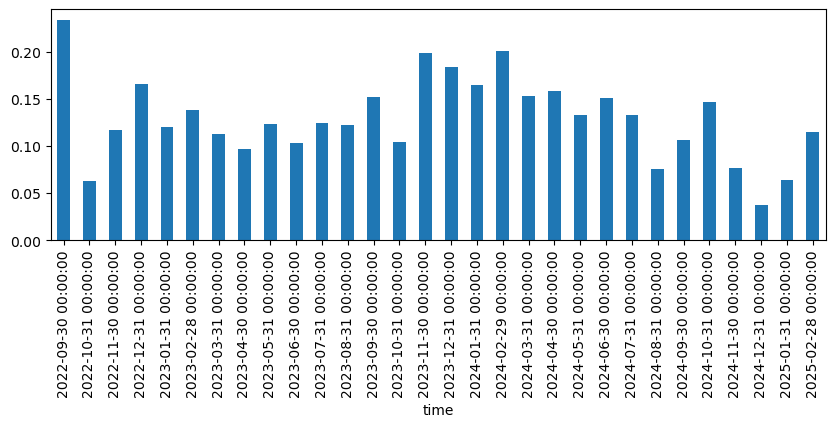

In [189]:
mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
(df.loc[mask_data, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            roc_auc_score(x['target'], x['y_pred'])
                                                                                                          ) - 0.5).plot.bar()

#### 2. WIN

In [193]:
np.quantile(df.loc[mask_train, 'y_pred'], q=q), np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

(0.2769661975054756, 0.31734904420401994)

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_96751/1886071299.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


<Axes: xlabel='time'>

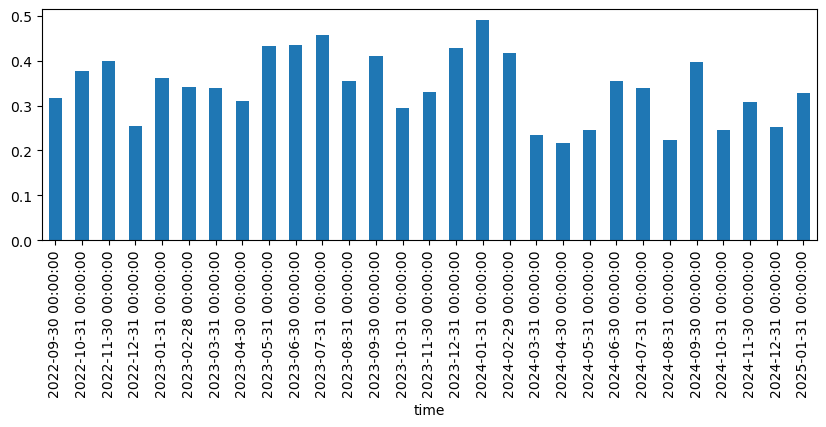

In [196]:
q = 0.95
col_target = 'target'

mask_last_bin = df['y_pred'] > np.quantile(df.loc[mask_train, 'y_pred'], q=q)

mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            x[col_target].mean()).plot.bar()

#### 3. income_rate

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_96751/3266133954.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


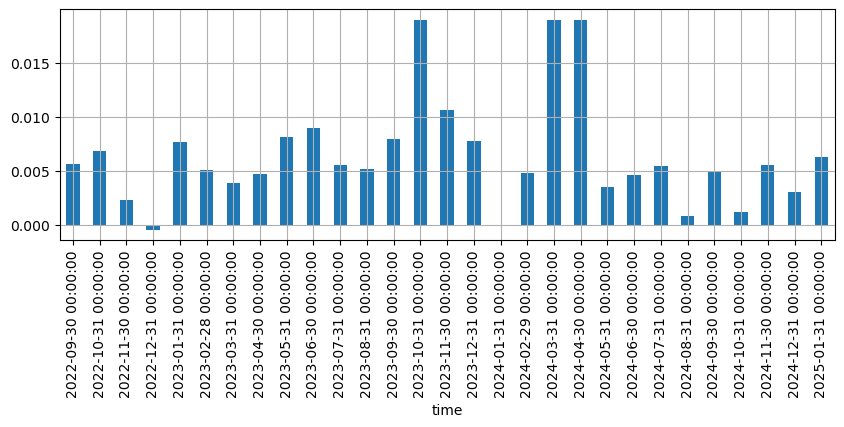

In [200]:
q = 0.95
col_target = 'income_rate'

mask_last_bin = df['y_pred'] > np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
(df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            x[col_target].mean()) -1).plot.bar()
plt.grid()

#### 4. Отложенная выборка

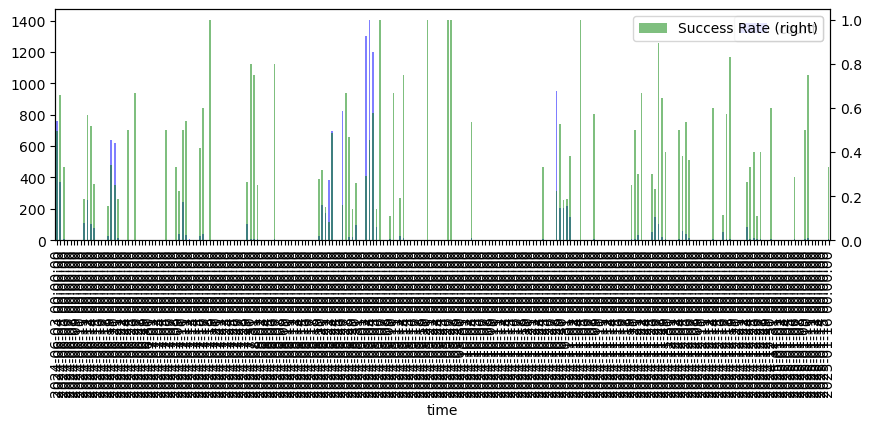

INCOME_RATE


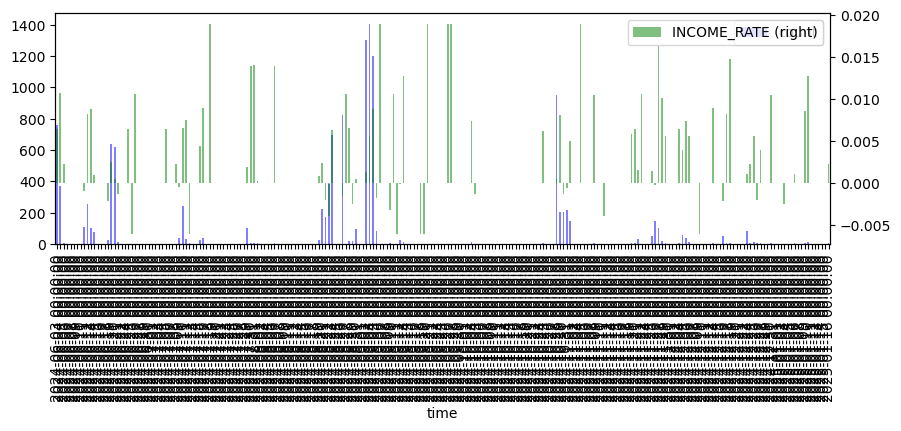

In [207]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.95
freq='D'

mask_data = mask_valid|mask_test|mask_test2|mask_test3

threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] > threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [210]:
#y_test3

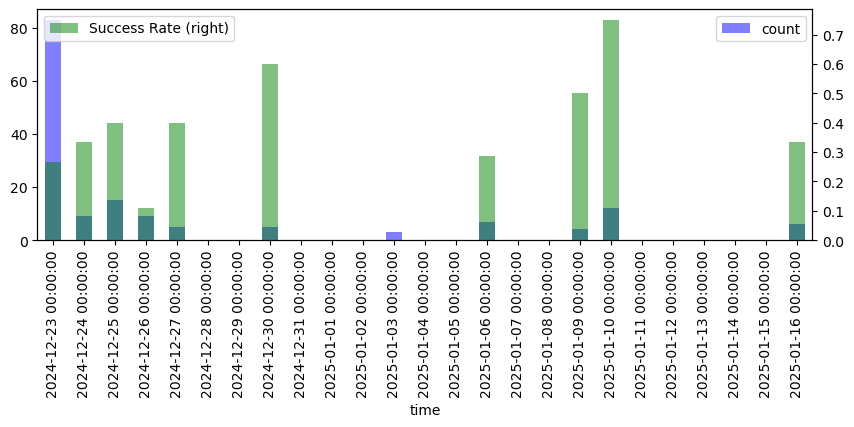

INCOME_RATE


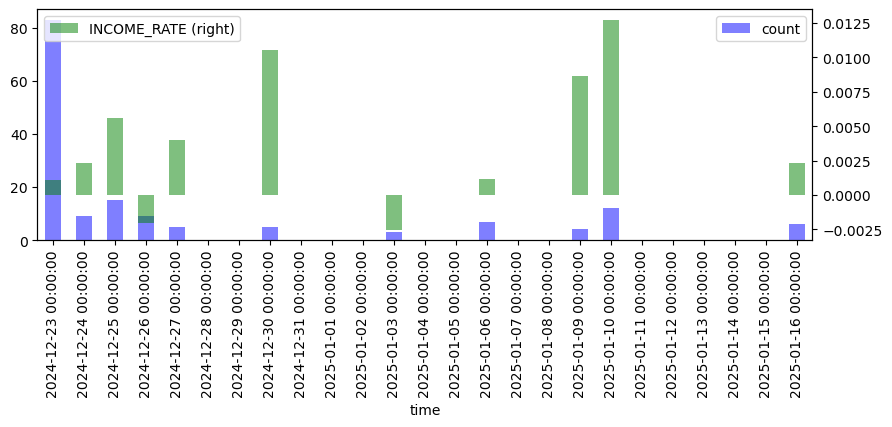

In [212]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.95
freq='D'


mask_data = mask_test3


threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] > threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [215]:
#mean_income_rate_by_day
(df.loc[mask_valid&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean(), (df.loc[mask_test&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean(), (df.loc[mask_test2&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean()


(0.004861773257793937, 0.004585833218139319, 0.00535436511790246)

In [217]:
df.loc[mask_valid&mask_last_bin, 'time'].dt.date.nunique(), df.loc[mask_test&mask_last_bin, 'time'].dt.date.nunique(),  df.loc[mask_test2&mask_last_bin, 'time'].dt.date.nunique()


(26, 27, 29)

In [219]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.95)

In [221]:
#sum_income_rate
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.06467289077809608, 0.06334848678080827, 0.05789974483426728)

In [224]:
#test3
(df.loc[mask_test3&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean()

0.003983524557849702

In [226]:
df.loc[mask_test3&mask_last_bin, 'time'].dt.date.nunique()

11

In [228]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.032133764766654256

In [232]:
mask_data = mask_valid | mask_test | mask_test2

In [234]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()


/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_96751/1640586492.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.003019397033404011

In [237]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_valid&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_96751/1656526771.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_valid&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0007307692307692613

In [239]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_96751/192763211.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0032592592592593033

In [241]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test2&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_96751/1559495362.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test2&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.004847950232383686

In [243]:
n = 1
pd.set_option('display.max_rows', 200)
(df.loc[mask_test3&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_96751/1398374837.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test3&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.008485635697313492

#### Points in life

In [247]:
threshold

0.31734904420401994

In [250]:
mask_dev = df['time'] > pd.Timestamp('2025-01-20')
df.loc[mask_dev, 'y_pred'] = model.predict(df.loc[mask_dev, features_fe])

threshold = 0.3072487941255682
df.loc[mask_dev, ['time', 'y_pred']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: (x['y_pred'] >= threshold).sum())

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_96751/860419480.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_dev, ['time', 'y_pred']].groupby(pd.Grouper(key='time', freq='D')).apply(


time
2025-01-20    0
2025-01-21    0
2025-01-22    0
2025-01-23    0
2025-01-24    0
2025-01-25    0
2025-01-26    0
2025-01-27    0
2025-01-28    1
2025-01-29    0
2025-01-30    0
2025-01-31    0
2025-02-01    0
2025-02-02    0
2025-02-03    0
2025-02-04    0
Freq: D, dtype: int64

In [642]:
df.loc[(df['y_pred'] > threshold) & mask_dev]

,time,close,ticker,index_1day,close_w1_roc,volume_w1_roc,tmos_close_w1_roc,close_w5_norm_std,close_w5_mean_abs_pct,close_w5_alpha,close_w5_rsi,close_w5_roc,volume_w5_norm_std,volume_w5_mean_abs_pct,volume_w5_alpha,volume_w5_rsi,volume_w5_roc,tmos_close_w5_norm_std,tmos_close_w5_mean_abs_pct,tmos_close_w5_alpha,tmos_close_w5_rsi,tmos_close_w5_roc,close_w14_norm_std,close_w14_mean_abs_pct,close_w14_alpha,close_w14_rsi,close_w14_roc,volume_w14_norm_std,volume_w14_mean_abs_pct,volume_w14_alpha,volume_w14_rsi,volume_w14_roc,tmos_close_w14_norm_std,tmos_close_w14_mean_abs_pct,tmos_close_w14_alpha,tmos_close_w14_rsi,tmos_close_w14_roc,close_w70_norm_std,close_w70_mean_abs_pct,close_w70_alpha,close_w70_rsi,close_w70_roc,close_w70_lvl_1-1.005,close_w70_lvl_-0.995-1,close_w70_lvl_1.005-1.01,close_w70_lvl_-0.99-0.995,close_w70_lvl_1.01-1.02,close_w70_lvl_-0.98-0.99,close_w70_lvl_1.02-1.03,close_w70_lvl_-0.97-0.98,...,close_1day_w5_ma_up_3std/close_1day,volume_1day_w5_ma_low_2std/volume_1day,volume_1day_w5_ma_up_2std/volume_1day,volume_1day_w5_ma_low_3std/volume_1day,volume_1day_w5_ma_up_3std/volume_1day,tmos_close_1day_w5_ma_low_2std/tmos_close_1day,tmos_close_1day_w5_ma_up_2std/tmos_close_1day,tmos_close_1day_w5_ma_low_3std/tmos_close_1day,tmos_close_1day_w5_ma_up_3std/tmos_close_1day,close_1day_w20_ma_low_2std/close_1day,close_1day_w20_ma_up_2std/close_1day,close_1day_w20_ma_low_3std/close_1day,close_1day_w20_ma_up_3std/close_1day,volume_1day_w20_ma_low_2std/volume_1day,volume_1day_w20_ma_up_2std/volume_1day,volume_1day_w20_ma_low_3std/volume_1day,volume_1day_w20_ma_up_3std/volume_1day,tmos_close_1day_w20_ma_low_2std/tmos_close_1day,tmos_close_1day_w20_ma_up_2std/tmos_close_1day,tmos_close_1day_w20_ma_low_3std/tmos_close_1day,tmos_close_1day_w20_ma_up_3std/tmos_close_1day,close_1day_w100_ma_low_2std/close_1day,close_1day_w100_ma_up_2std/close_1day,close_1day_w100_ma_low_3std/close_1day,close_1day_w100_ma_up_3std/close_1day,volume_1day_w100_ma_low_2std/volume_1day,volume_1day_w100_ma_up_2std/volume_1day,volume_1day_w100_ma_low_3std/volume_1day,volume_1day_w100_ma_up_3std/volume_1day,tmos_close_1day_w100_ma_low_2std/tmos_close_1day,tmos_close_1day_w100_ma_up_2std/tmos_close_1day,tmos_close_1day_w100_ma_low_3std/tmos_close_1day,tmos_close_1day_w100_ma_up_3std/tmos_close_1day,close_1day_w3_min/close_1day_w3_max,volume_1day_w3_min/volume_1day_w3_max,tmos_close_1day_w3_min/tmos_close_1day_w3_max,close_1day_w5_min/close_1day_w5_max,volume_1day_w5_min/volume_1day_w5_max,tmos_close_1day_w5_min/tmos_close_1day_w5_max,close_1day_w20_min/close_1day_w20_max,volume_1day_w20_min/volume_1day_w20_max,tmos_close_1day_w20_min/tmos_close_1day_w20_max,result,delta_time,income_rate,res_price,res_ind,target,ticker_code,y_pred
36592,2025-01-28 12:00:00,0.353700,OGKB,2785.0,-0.014489,3.202935,-0.003165,0.011417,0.005544,-365.644257,0.000000,-0.027495,1.154666,33.751759,3.632997e-05,60.506290,3.298597,0.001938,0.000949,-116.666664,0.000000,-0.004739,0.012999,0.004843,-778.131104,22.672064,-0.036765,1.177171,13.838688,0.000083,54.220161,1.363458,0.004217,0.001684,-138.278244,20.000000,-0.014085,0.024860,0.006591,-1247.396362,48.537006,-0.014214,0.0,0.0,0.0,0.0,2.0,0.0,7.0,0.0,...,1.125469,-1.385655,6.294559,-3.305709,8.214612,0.998333,1.026944,0.991180,1.034096,0.843153,1.094388,0.780344,1.157197,-2.654034,6.456709,-4.931720,8.734394,0.936570,1.037522,0.911332,1.062760,0.774300,1.082184,0.697329,1.159155,-1.393869,3.368218,-2.584390,4.558740,0.821885,1.018684,0.772686,1.067883,0.964712,0.335849,0.982919,0.932307,0.155284,0.982919,0.827692,0.032823,0.925581,WIN,0 days 09:00:00,1.019,0.3623,36637,1,76,0.314052
442346,2025-01-20 12:00:00,252.199997,GTRK,38806.0,-0.017147,-0.490334,-0.009274,0.012797,0.009818,-0.347830,18.110237,-0.031118,0.620801,0.852981,-2.299708e-05,19.046721,-0.907505,0.005208,0.004949,-8.849558,37.500000,-0.006202,0.019548,0.008143,0.595041,57.093426,0.016526,1.446928,1.041347,0.000061,50.484890,0.362851,0.004551,0.002770,95.515694,56.000000,0

### Обучить на всем (эксперимент неудачен)

In [250]:
mask_data = mask_train | mask_valid | mask_test | mask_test2

D_data = lgbm.Dataset(df.loc[mask_data, features_fe], label=df.loc[mask_data, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)


D_data.income_rate = df.loc[mask_data, 'income_rate'].values

D_data.time = df.loc[mask_data, 'time'].values

In [263]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features_fe], label=df.loc[mask_test3, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values

In [265]:
features_fe = ['close_1day_w5_norm_std/close_1day_w100_norm_std',
 'tmos_close_1day_w5_ma_up_3std/tmos_close_1day',
 'tmos_close_1day_w5_std/tmos_close_1day_w100_std',
 'close_1day_w3_std/close_1day_w100_std',
 'close_1day_w20_roc',
 'close_w70_lvl_1.02-1.03',
 'tmos_close_1day_w5_norm_std',
 'volume_1day_w20_rsi',
 'close_1day_w20_norm_std',
 'close_w14_ma_low_3std/close',
 'tmos_close_w14_max/tmos_close',
 'close_1day_w5_ma/close_1day_w100_ma',
 'tmos_close/tmos_close_w70_ma',
 'tmos_close_w70_lvl_1-1.005',
 'close_w14_mean_abs_pct/close_w70_mean_abs_pct',
 'tmos_close_1day_w20_rsi',
 'tmos_close_1day_w5_min/tmos_close_1day_w5_max',
 'close_1day_w100_lvl_1.02-1.03',
 'close_1day_w20_min/close_1day_w20_max',
 'close_w14_mean_abs_pct']

params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.5000000000000001,
 'bagging_fraction': 0.3500000000000001,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 #'metric': 'auc',
          'num_iteration' : 153,
# 'early_stopping': 50
         }

model = lgbm.train(params,  num_boost_round=2_000, train_set=D_data)

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [269]:
model.num_trees()

153

In [271]:
y_pred_data= model.predict(D_data.data)


df["y_pred"] = None
df.loc[mask_data, 'y_pred'] = y_pred_data

roc_auc_score(D_data.label, y_pred_data)

0.6975954151975302

In [273]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.5597503841597529

In [275]:
threshold = 0.3668169577019395#np.quantile(df.loc[mask_data, 'y_pred'], q=0.99)
threshold
#0.3668169577019395

0.3668169577019395

In [277]:
mean_income_rate_point(D_data, y_pred_data, threshold=threshold)

0.015038490295410156

In [279]:
mean_income_rate_day(D_data, y_pred_data, threshold=threshold)

0.0070446134

In [281]:
mean_income_rate_month(D_data, y_pred_data, threshold=threshold)

0.053166893293272774

In [283]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=threshold)

0.010228395462036133

In [285]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=threshold)

0.010330456

In [287]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.09090801551938058

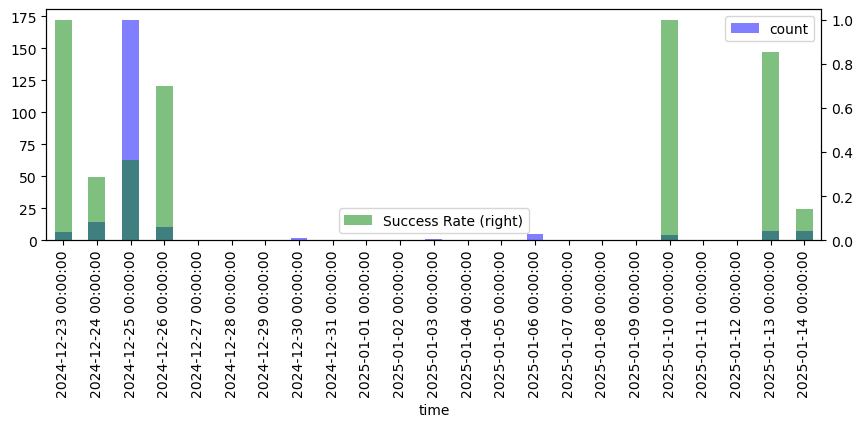

INCOME_RATE


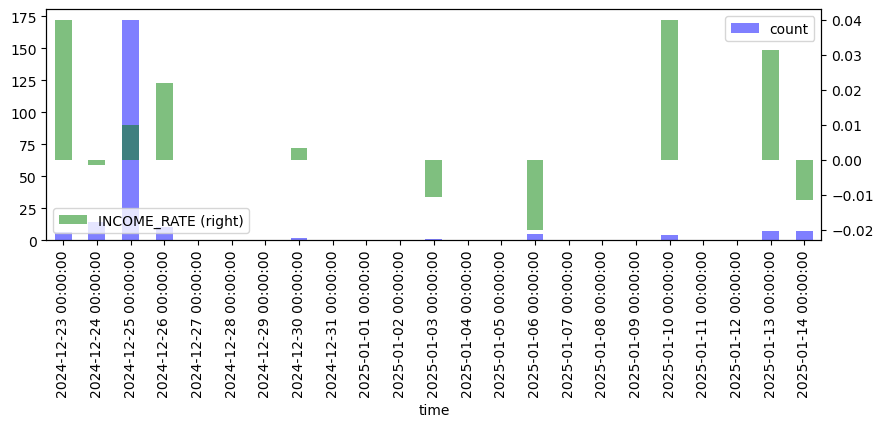

In [289]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.99
freq='D'


mask_data = mask_test3


#threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] > threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()